# Time Series Forecasting

## Downloading Datasets

In [ ]:
import kagglehub
import os

# Download latest version
yahoo_path = kagglehub.dataset_download("arashnic/time-series-forecasting-with-yahoo-stock-price")
yahoo_path = os.path.join(yahoo_path, "yahoo_stock.csv")

gold_path = kagglehub.dataset_download("sahilwagh/gold-stock-prices")
gold_path = os.path.join(gold_path, 'goldstock v2.csv')

apple_path = kagglehub.dataset_download("mayankanand2701/apple-stock-price-dataset")
apple_path = os.path.join(apple_path, "Apple Dataset.csv")

store_path = kagglehub.dataset_download("rohitsahoo/sales-forecasting")
store_path = os.path.join(store_path, 'train.csv')

climate_path = kagglehub.dataset_download("sumanthvrao/daily-climate-time-series-data")

print("Path to dataset files:", climate_path)
print("Apple Stock dataset:", apple_path)
print("Yahoo stock dataset:", yahoo_path)
print("Gold stock dataset:", gold_path)
print("Path to dataset files:", store_path)


## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
import joblib
import scipy.stats as st
import warnings
import statsmodels.api as sm

warnings.filterwarnings("ignore")


sns.set_style("whitegrid")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device = ", device)

## Installing Packages

In [ ]:
!pip install statsmodels

## Common Utilties

In [ ]:
def iqr_outliers(arr, prop=1.5):
    """
    Identifies and replaces outliers in a specified column of a DataFrame using the IQR method.

    Args:
        arr: Numpy Array.
        prop: proportion of outliers to be removed, default = 1.5

    Returns:
        A DataFrame with outliers replaced by lower and upper bounds.
    """
    Q1 = np.quantile(arr,0.25)
    Q3 = np.quantile(arr,0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - prop * IQR
    upper_bound = Q3 + prop * IQR
    arr = np.where(arr < lower_bound, lower_bound, arr)
    arr = np.where(arr > upper_bound, upper_bound, arr)

    return arr

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(data):
    """
    Plots the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for a given time series.

    Args:
        data (numpy.ndarray): A 1D numpy array representing the time series data.
    """
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    plot_acf(data, lags=40, ax=axes[0])
    axes[0].set_title("Autocorrelation Function (ACF)")

    plot_pacf(data, lags=40, ax=axes[1])
    axes[1].set_title("Partial Autocorrelation Function (PACF)")

    plt.tight_layout()
    plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

def is_stationary(series):
    """
    Performs the Augmented Dickey-Fuller test on a time series and returns True if the series is stationary.

    Args:
        series (numpy.ndarray): A 1D numpy array representing the time series data.

    Returns:
        bool: True if the series is stationary, False otherwise.
    """
    result = adfuller(series)
    p_value = result[1]
    return p_value < 0.05

In [ ]:
def plot_losses(model_results, figsize=(12,6)):

    plt.figure(figsize=figsize)
    plt.plot(model_results['epoch'], model_results['train_loss'], label="Train")
    plt.plot(model_results['epoch'], model_results['test_loss'], label="Test")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss curves")
    plt.legend()
    plt.show()

In [ ]:
def plot_predictions(original,train_predictions, figsize=(12,6)):

    plt.figure(figsize=figsize)
    plt.plot(original, label="Original")
    plt.plot(train_predictions, label="Predicted")
    plt.ylabel("Prediction")
    plt.title("Predictions")
    plt.legend()
    plt.show()

In [ ]:
def create_sequences(df, sequence_length, target_length, features, target_attrs):
    sequences = []
    targets = []
    for i in range(len(df) - sequence_length - target_length + 1):
        sequence = df[features].iloc[i:i + sequence_length]
        target = df[target_attrs].iloc[i + sequence_length:i + sequence_length + target_length]
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)


In [ ]:
def lstm_predict(model,prices,scaler = None):
    X = prices.reshape(1,-1)
    X = torch.tensor(X).type(torch.float32).to(device)
    X = X.unsqueeze(2)
    
    model.eval()
    with torch.no_grad():
        y = model(X)

    X = X.squeeze(2)
    if scaler is not None:
        X = scaler.inverse_transform(X.cpu().numpy())
        y = scaler.inverse_transform(y.cpu().numpy())

    return X[0], y[0][0]

def xgb_predict(model, prices, scaler = None):
    X = prices.reshape(1, -1)
    y = model.predict(X).reshape(-1,1)
    
    if scaler is not None:
        X = scaler.inverse_transform(X)
        y = scaler.inverse_transform(y)

    return X[0], y[0][0]


In [ ]:
def lstm_training(model: nn.Module,
                  criterion,
                  optimizer,
                  X_train_tensor: torch.Tensor,
                  y_train_tensor: torch.Tensor,
                  X_test_tensor: torch.Tensor,
                  y_test_tensor: torch.Tensor, 
                  batch_size: int, 
                  num_epochs: int) -> pd.DataFrame:
    train_losses = []
    test_losses = []
    
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        train_loss = 0
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]
            batch_y = y_train_tensor[i:i+batch_size]

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= (len(X_train_tensor) / batch_size)
        train_losses.append(train_loss)

    
        model.eval()
        with torch.no_grad():
            test_loss = 0
            for i in range(0, len(X_test_tensor), batch_size):
                batch_X = X_test_tensor[i:i+batch_size]
                batch_y = y_test_tensor[i:i+batch_size]
            
                outputs = model(batch_X)
                test_loss += criterion(outputs, batch_y).item()
            
            
            test_loss /= (len(X_test_tensor) / batch_size)
            test_losses.append(test_loss)

    
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    results_df = pd.DataFrame({
        'epoch': np.arange(1, num_epochs+1),
        'train_loss': np.array(train_losses),
        'test_loss': np.array(test_losses)
    })

    return results_df

In [ ]:

def xgb_train(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    xgb_predictions = model.predict(X_test)
    xgb_train_predictions = model.predict(X_train)

    test_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
    train_rmse = np.sqrt(mean_squared_error(y_train, xgb_train_predictions))
    print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
    return xgb_train_predictions, xgb_predictions


In [ ]:
def lstm_forecast(model, inputs):
    inputs, out = lstm_predict(model, inputs)
    plt.plot(np.arange(len(inputs)),inputs, linestyle='dotted', label='input',  marker='o', markersize=5)
    plt.plot(np.arange(len(inputs), len(inputs)+1),out, linestyle='dotted', label='predicted', color='green', marker='o', markersize=5)
    plt.legend()
    plt.title('LSTM Forecasting')
    plt.show()

def xgb_forecast(model, inputs):
    inputs, out = xgb_predict(model, inputs)
    plt.plot(np.arange(1,len(inputs)+1),inputs, 
             linestyle='dotted', label='input',  
             marker='o', markersize=5)
    plt.plot(np.arange(len(inputs)+1, len(inputs)+2),np.array([out]), 
             linestyle='dotted', label='forecast',
             color='green', marker='o', markersize=5)
    plt.legend()
    plt.title('XGB Forecasting')
    plt.show()


## Yahoo Stock Price Analysis

### Reading Data

In [41]:
yahoo_df = pd.read_csv(yahoo_path, parse_dates=["Date"])
yahoo_df.rename(columns={'Adj Close': 'adj_close'}, inplace=True)
yahoo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1825 non-null   datetime64[ns]
 1   High       1825 non-null   float64       
 2   Low        1825 non-null   float64       
 3   Open       1825 non-null   float64       
 4   Close      1825 non-null   float64       
 5   Volume     1825 non-null   float64       
 6   adj_close  1825 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 99.9 KB


### Data Visualisation

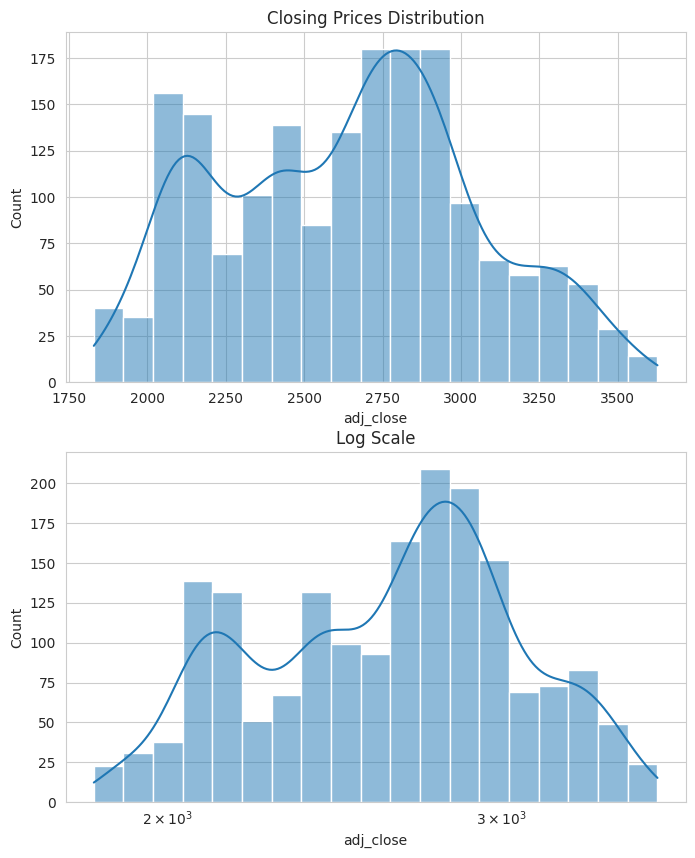

In [42]:
fig, axs = plt.subplots(2, figsize=(8,10))
sns.histplot(data=yahoo_df, x='adj_close', ax=axs[0], kde=True)
axs[0].set_title('Closing Prices Distribution')
sns.histplot(data=yahoo_df, x='adj_close', ax=axs[1], log_scale=True, kde=True)
axs[1].set_title('Log Scale')
plt.show()

There isn't much noticable differences between distribution of closing prices and their log transformations

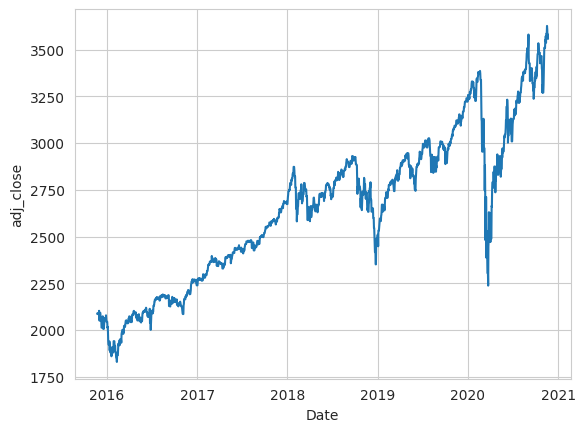

In [43]:
sns.lineplot(data=yahoo_df, x='Date', y='adj_close')
plt.show()

The time series is following an uptrend, which implies, that subtraction of rolling day averages will yield a stationary series

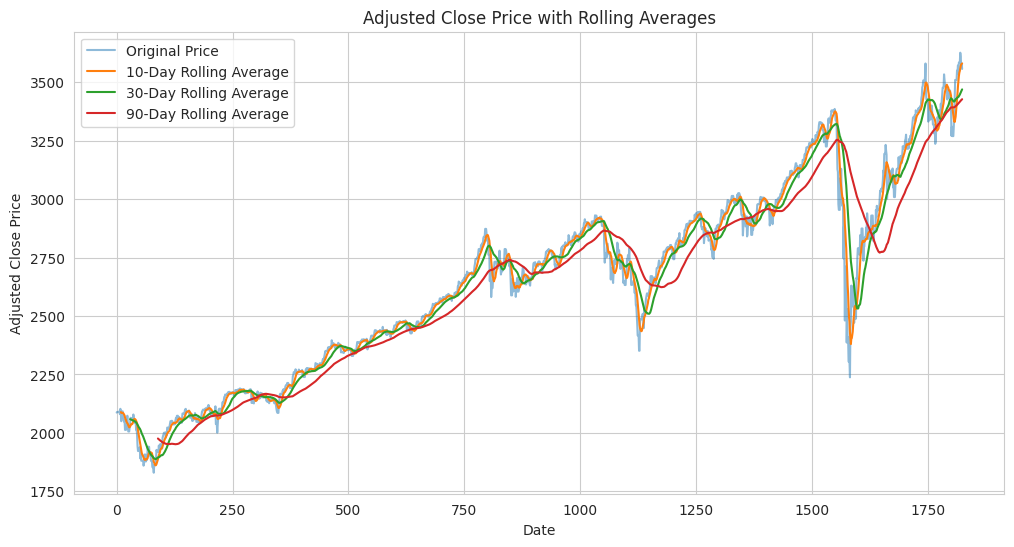

In [44]:
# Calculate rolling averages with different windows
rolling_10d = yahoo_df['adj_close'].rolling(window=10).mean()
rolling_30d = yahoo_df['adj_close'].rolling(window=30).mean()
rolling_90d = yahoo_df['adj_close'].rolling(window=90).mean()

# Plot the rolling averages
plt.figure(figsize=(12, 6))
plt.plot(yahoo_df['adj_close'], label='Original Price', alpha=0.5)
plt.plot(rolling_10d, label='10-Day Rolling Average')
plt.plot(rolling_30d, label='30-Day Rolling Average')
plt.plot(rolling_90d, label='90-Day Rolling Average')
plt.title('Adjusted Close Price with Rolling Averages')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()

Now all differences are adjusted with in -100 and 100

### Data Preprocessing

In [45]:
from sklearn.preprocessing import MinMaxScaler
yahoo_scaler = MinMaxScaler()
yahoo_df['adj_close_scaled'] = yahoo_scaler.fit_transform(yahoo_df[['adj_close']])

Normalised differences using standard scaler and actual prices using min_max scaler to preserve the trend

In [46]:

seq_length = 10
forecast_length = 1
target_attrs = ['adj_close_scaled']
features = ['adj_close_scaled']
X, y = create_sequences(yahoo_df, seq_length, forecast_length,features, target_attrs)

y = np.squeeze(y, 1)
X_train, y_train = X[:int(0.8 * len(X))], y[:int(0.8 * len(y))]
X_test, y_test = X[int(0.8 * len(X)):], y[int(0.8 * len(y)):]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
print(X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape)


X_train shape: (1452, 10, 1)
y_train shape: (1452, 1)
X_test shape: (363, 10, 1)
y_test shape: (363, 1)
torch.Size([1452, 10, 1]) torch.Size([1452, 1]) torch.Size([363, 10, 1]) torch.Size([363, 1])


### Model building


#### LSTM Model

In [47]:
import torch
import torch.nn as nn

class YahooLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(YahooLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)

        self.fc = nn.Sequential(
              nn.ReLU(),
              nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


In [48]:
input_size = 1
hidden_size = 128
num_layers = 1
output_size = 1

yahoo_lstm_model = YahooLSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(yahoo_lstm_model.parameters(), lr=0.001)

yahoo_lstm_model

YahooLSTMModel(
  (lstm): LSTM(1, 128, batch_first=True)
  (fc): Sequential(
    (0): ReLU()
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [49]:
# Training the model
yahoo_lstm_results = lstm_training(
                yahoo_lstm_model,
                criterion,
                optimizer,
                X_train_tensor,
                y_train_tensor,
                X_test_tensor,
                y_test_tensor,
                batch_size=16,
                num_epochs=500
        )


Epoch [1/500], Loss: 0.0301, Test Loss: 0.0657
Epoch [2/500], Loss: 0.0856, Test Loss: 0.1381
Epoch [3/500], Loss: 0.1555, Test Loss: 0.0226
Epoch [4/500], Loss: 0.1213, Test Loss: 0.1142
Epoch [5/500], Loss: 0.0842, Test Loss: 0.3307
Epoch [6/500], Loss: 0.0639, Test Loss: 0.2466
Epoch [7/500], Loss: 0.0471, Test Loss: 0.2287
Epoch [8/500], Loss: 0.0487, Test Loss: 0.2314
Epoch [9/500], Loss: 0.0486, Test Loss: 0.2293
Epoch [10/500], Loss: 0.0484, Test Loss: 0.2277
Epoch [11/500], Loss: 0.0483, Test Loss: 0.2258
Epoch [12/500], Loss: 0.0481, Test Loss: 0.2236
Epoch [13/500], Loss: 0.0478, Test Loss: 0.2209
Epoch [14/500], Loss: 0.0475, Test Loss: 0.2176
Epoch [15/500], Loss: 0.0471, Test Loss: 0.2135
Epoch [16/500], Loss: 0.0466, Test Loss: 0.2079
Epoch [17/500], Loss: 0.0471, Test Loss: 0.2122
Epoch [18/500], Loss: 0.0399, Test Loss: 0.1728
Epoch [19/500], Loss: 0.0541, Test Loss: 0.2359
Epoch [20/500], Loss: 0.0463, Test Loss: 0.2027
Epoch [21/500], Loss: 0.0455, Test Loss: 0.2067
E

KeyboardInterrupt: 

In [ ]:
plot_losses(yahoo_lstm_results, figsize=(12,6))

In [ ]:
yahoo_lstm_model.eval()

with torch.no_grad():
    predicted = yahoo_lstm_model(X_train_tensor)

plot_predictions(y_train_seq, predicted.cpu().numpy(), figsize=(12,6))


In [ ]:
yahoo_lstm_model.eval()
with torch.no_grad():
      predicted = yahoo_lstm_model(X_test_tensor)
    
plot_predictions(y_test_seq, predicted.cpu().numpy(), figsize=(12,6))


#### XGBoost Model

In [ ]:

import xgboost as xgb
from sklearn.metrics import mean_squared_error

yahoo_xgb_model = xgb.XGBRegressor(n_estimators=300, objective='reg:squarederror')  
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)


xgb_train_preds, xgb_test_preds = xgb_train(yahoo_xgb_model, X_train_xgb, y_train, X_test_xgb, y_test)

In [ ]:
plot_predictions(y_train_seq, xgb_train_preds, figsize=(12,6))

In [ ]:
plot_predictions(y_test_seq, xgb_test_preds, figsize=(12,6))

In [ ]:
# make predictions
prices = yahoo_df['adj_close_scaled'].iloc[10:20].to_numpy()
print(lstm_predict(yahoo_lstm_model, yahoo_scaler, prices))
print(xgb_predict(yahoo_xgb_model, yahoo_scaler, prices))

In [ ]:
# save the model
torch.save(yahoo_lstm_model.state_dict(), "yahoo_lstm_model.pth")
joblib.dump(yahoo_xgb_model,"yahoo_xgb_model.joblib")
joblib.dump(yahoo_scaler, "yahoo_scaler.joblib")
yahoo_lstm_results.to_csv('yahoo_xgb_results.csv', index=False)

## Gold ETF Price Analysis

### Reading The data

In [ ]:
gold_df = pd.read_csv(gold_path, parse_dates=['Date'])
gold_df.drop(columns=['Unnamed: 0'], inplace=True)
gold_df.rename(columns={'Close/Last': 'Close'}, inplace=True)
gold_df = gold_df[::-1].reset_index().drop(columns=['index'])
gold_df.head()

In [ ]:
gold_df.info()

### Data Visualisation

In [ ]:
sns.lineplot(data=gold_df, x='Date', y='Close')
plt.show()

In [ ]:
fig,axs = plt.subplots(2, figsize=(8,10))

sns.histplot(data=gold_df, x='Close', bins=20, ax=axs[0])
sns.histplot(data=gold_df, x='Close', bins=20, log_scale=True, ax=axs[1])
axs[0].set_title("Closing Prices distribution")
axs[1].set_title('Log scale')
plt.show()

There isn't much noticable difference in log transformation

In [ ]:
# Calculate rolling averages with different windows
rolling_10d = gold_df['Close'].rolling(window=10).mean()
rolling_30d = gold_df['Close'].rolling(window=30).mean()
rolling_90d = gold_df['Close'].rolling(window=90).mean()

# Plot the rolling averages
plt.figure(figsize=(12, 6))
plt.plot(gold_df['Close'], label='Original Price', alpha=0.5)
plt.plot(rolling_10d, label='10-Day Rolling Average')
plt.plot(rolling_30d, label='30-Day Rolling Average')
plt.plot(rolling_90d, label='90-Day Rolling Average')
plt.title('Adjusted Close Price with Rolling Averages')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()

10-day rolling averages, perfectly approximating the series, we are choosing the 10 as the sequence number

### Data Preprocessing

In [ ]:
from sklearn.preprocessing import MinMaxScaler

gold_scaler = MinMaxScaler(feature_range=(0,1))
gold_df['Close_scaled'] = gold_scaler.fit_transform(gold_df[['Close']])

sns.lineplot(data=gold_df, x='Date', y='Close_scaled')
plt.show()
sns.histplot(data=gold_df, x='Close_scaled', bins=20)
plt.show()

In [ ]:
seq_length = 10
forecast_length = 1
target = ['Close_scaled']
features = ['Close_scaled']
X, y = create_sequences(gold_df, seq_length, 1, target, features)

y = np.squeeze(y, 1)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.35,
                                                    random_state=42,
                                                    shuffle=False)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

print("Shape of X_train_tensor:", X_train_tensor.shape)
print("Shape of y_train_tensor:", y_train_tensor.shape)
print("Shape of X_test_tensor:", X_test_tensor.shape)
print("Shape of y_test_tensor:", y_test_tensor.shape)

### Model Building

#### LSTM Model

In [ ]:
class GoldLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(GoldLSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out



In [ ]:
# Define hyperparameters
input_size = 1 
hidden_size = 10
num_layers = 1
output_size = 1
learning_rate = 0.001
num_epochs = 200
batch_size = 16
dropout = 0

gold_lstm_model = GoldLSTMModel(input_size, hidden_size,
                            num_layers, output_size, dropout).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(gold_lstm_model.parameters(), lr=learning_rate)


In [ ]:
gold_lstm_results = lstm_training(gold_lstm_model,X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,16,200)

#### Loss Curves

In [ ]:
plot_losses(gold_lstm_results)

#### Plot Predictions

In [ ]:

gold_lstm_model.eval()

with torch.no_grad():
    train_predictions = gold_lstm_model(X_train_tensor)

plot_predictions(y_train, train_predictions, figsize=(12,6))


In [ ]:

gold_lstm_model.eval()

with torch.no_grad():
    test_predictions = gold_lstm_model(X_test_tensor)


plot_predictions(y_test, test_predictions.cpu().numpy(), figsize=(12,6))


#### XGBoost Model

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Reshape the data for XGBoost
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)

# Create and train the XGBoost regressor
gold_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)

gold_train_preds,gold_test_preds = xgb_train(gold_xgb_model, 
                                            X_train_xgb, y_train,
                                            X_test_xgb, y_test)


#### XGBoost predictions

In [ ]:
plot_predictions(y_test, gold_test_preds, figsize=(12,6))

In [ ]:
plot_predictions(y_train, gold_train_preds, figsize=(12,6))

In [ ]:
print(lstm_predict(gold_lstm_model, gold_scaler, 
                   gold_df['Close_scaled'].iloc[-30:-20].to_numpy()))
print(xgb_predict(gold_xgb_model, gold_scaler, 
                  gold_df['Close_scaled'].iloc[-30:-20].to_numpy()))

#### Saving the results

In [ ]:
torch.save(gold_lstm_model.state_dict(), 'gold_lstm_model.pth')
joblib.dump(gold_scaler, 'gold_scaler.joblib')
joblib.dump(gold_xgb_model, 'gold_xgb_model.joblib')
gold_lstm_results.to_csv('gold_lstm_results.csv')

## Apple Stock Analysis

### Reading the Appple Data

In [ ]:
apple_df = pd.read_csv(apple_path, parse_dates=['Date'])
apple_df.rename(columns={'Adj Close': 'adj_close'}, inplace=True)
apple_df.head()

In [ ]:
apple_df.info()

### Data Visualisation

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(apple_df['Date'], apple_df['adj_close'])
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Apple Stock Adjusted Close Price Over Time')
plt.grid(True)
plt.show()

As actual trend started from 2010, we are starting analysis from 2010

In [ ]:
apple_df_2010 = apple_df[apple_df['Date'].dt.year >= 2010]

plt.figure(figsize=(12, 6))
plt.plot(apple_df_2010['Date'], apple_df_2010['adj_close'])
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Apple Stock Adjusted Close Price in 2005')
plt.grid(True)
plt.show()

In [ ]:
sns.histplot(apple_df_2010['Volume'], kde=True, log_scale=True, bins=50)
plt.xlabel('Volume')
plt.ylabel('Density')
plt.title('Distribution of Volume in 2005')
plt.show()

In [ ]:
sns.lineplot(data=apple_df_2010, x='Date', y='Volume')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(x=np.log(apple_df_2010['Volume']), y=apple_df_2010['adj_close'], scatter_kws={'alpha': 0.5})
plt.xlabel('Volume')
plt.ylabel('Adjusted Close Price')
plt.title('Correlation between Volume and Adjusted Close Price')
plt.grid(True)
plt.show()

correlation = np.log(apple_df_2010['Volume']).corr(apple_df_2010['adj_close'])
print(f"Correlation coefficient: {correlation}")

**There is a negative correlation between closing price and traded volumes**

In [ ]:
apple_df_2010.loc[:, 'volume_log'] = apple_df_2010['Volume'].apply(np.log)
apple_df_2010.head()

In [ ]:
apple_data = apple_df_2010[['adj_close', 'volume_log']]
apple_data.head()

### Data Preprocessing

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Min-Max scaling for 'adj_close'
apple_close_scaler = MinMaxScaler(feature_range=(1, 10))
apple_data.loc[:,'adj_close_scaled'] = apple_close_scaler.fit_transform(apple_data[['adj_close']])

# Standard scaling for 'volume_log'
apple_volume_scaler = StandardScaler()
apple_data.loc[:, 'volume_log_scaled'] = apple_volume_scaler.fit_transform(apple_data[['volume_log']])

apple_data.describe()

In [ ]:
sns.histplot(apple_data['adj_close_scaled'], kde=True, log_scale=True, bins=50)
plt.xlabel('Closing price')
plt.ylabel('Density')
plt.title('Distribution of Volume in 2010')
plt.show()

In [ ]:
seq_length = 10
X, y = create_sequences(apple_data, seq_length, 1, ['adj_close_scaled'], ['adj_close_scaled'])
y = np.squeeze(y, 1)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

In [ ]:

test_size = 0.2
split_index = int(len(X) * (1 - test_size))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)


print("Shape of X_train_tensor:", X_train_tensor.shape)
print("Shape of y_train_tensor:", y_train_tensor.shape)
print("Shape of X_test_tensor:", X_test_tensor.shape)
print("Shape of y_test_tensor:", y_test_tensor.shape)

In [ ]:
class AppleLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(AppleLSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


In [ ]:
input_size = 1
hidden_size = 10
num_layers = 1
output_size = 1
learning_rate = 0.001
num_epochs = 200
batch_size = 16
dropout = 0

apple_lstm_model = AppleLSTMModel(input_size, hidden_size,
                                  num_layers, output_size, dropout).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(apple_lstm_model.parameters(), lr=learning_rate)

In [ ]:
# Training loop

apple_lstm_results = lstm_training(apple_lstm_model, X_train_tensor,
              y_train_tensor,
              X_test_tensor,
              y_test_tensor, batch_size, num_epochs)


In [ ]:
# apple_lstm_results = pd.DataFrame({
#     'epoch': np.arange(1, num_epochs+1),
#     'train_loss': train_losses,
#     'test_loss': test_losses
# })

plot_losses(apple_lstm_results)

**Plotting the Predictions**

In [ ]:
apple_lstm_model.eval()
with torch.no_grad():
    
    train_predictions = apple_lstm_model(X_train_tensor)

plot_predictions(y_train, train_predictions.cpu().numpy(), figsize=(12,6))

In [ ]:
apple_lstm_model.eval()
with torch.no_grad():
    
    test_predictions = apple_lstm_model(X_test_tensor)

plot_predictions(y_test, test_predictions.cpu().numpy(), figsize=(12,6))

#### XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Reshape the data for XGBoost
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)

# Create and train the XGBoost regressor
apple_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
apple_train_preds, apple_test_preds = xgb_train(apple_xgb_model, X_train_xgb, y_train, X_test_xgb, y_test)


#### Plotting the predictions

In [ ]:
plot_predictions(y_test, apple_test_preds, figsize=(12,6))

In [ ]:
plot_predictions(y_train, apple_train_preds, figsize=(12,6))

#### Predictions

In [ ]:
print("\nXGB Predict")
X, y = xgb_predict(apple_xgb_model, 
                   apple_close_scaler,apple_data['adj_close_scaled'].iloc[-30:-20].to_numpy())

print(X, y)
print("\nLSTM Predict")
X, y = lstm_predict(apple_lstm_model, 
                   apple_close_scaler,apple_data['adj_close_scaled'].iloc[-30:-20].to_numpy())

print(X, y)

#### Saving the results

In [ ]:

torch.save(apple_lstm_model.state_dict(), 'apple_lstm_model.pth')
joblib.dump(apple_close_scaler, 'apple_close_scaler.joblib')
joblib.dump(apple_xgb_model, 'apple_xgb_model.joblib')
apple_lstm_results.to_csv('apple_lstm_results.csv')

## Super Store Sales Forecasting

### Loading the data

In [18]:
store_df = pd.read_csv(store_path)
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [19]:
store_df.head()

Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Category Sub-Category  \
0      42420.0  South  FUR-BO-10001798        Furniture    Bookcases   
1      42420.0  South  FUR-CH-10000454        Furniture       Chairs   
2      90036.0   West  OFF-LA-10000240  Office Supplies       Labels   
3      33311.0  South  FUR-TA-10000577        Furniture       Tables   
4      33311.0  South  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name     Sales  
0                  Bush Somerset Collection Bookcase  261.9600  
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400  
2  Self-Adhesive Address Labels for Typewriters b...   14.6200  
3      Bretford CR4500 Series Slim Rectangular Table  957.5775  
4                     Eldon Fold 'N Roll Cart System   22.3680

In [20]:

store_df['Order Date'] = pd.to_datetime(store_df['Order Date'], format="%d/%m/%Y")
store_df['Ship Date'] = pd.to_datetime(store_df['Ship Date'], format="%d/%m/%Y")

store_df['Ship Mode'] = store_df['Ship Mode'].astype('category')
store_df['Segment'] = store_df['Segment'].astype('category')
store_df['Category'] = store_df['Category'].astype('category')
store_df['Sub-Category'] = store_df['Sub-Category'].astype('category')
store_df['Region'] = store_df['Region'].astype('category')

store_df.drop(columns = ['Customer Name', 'Product Name'], inplace=True)


In [21]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Row ID        9800 non-null   int64         
 1   Order ID      9800 non-null   object        
 2   Order Date    9800 non-null   datetime64[ns]
 3   Ship Date     9800 non-null   datetime64[ns]
 4   Ship Mode     9800 non-null   category      
 5   Customer ID   9800 non-null   object        
 6   Segment       9800 non-null   category      
 7   Country       9800 non-null   object        
 8   City          9800 non-null   object        
 9   State         9800 non-null   object        
 10  Postal Code   9789 non-null   float64       
 11  Region        9800 non-null   category      
 12  Product ID    9800 non-null   object        
 13  Category      9800 non-null   category      
 14  Sub-Category  9800 non-null   category      
 15  Sales         9800 non-null   float64 

### Data Visualization

In [22]:
avg_sales = store_df.groupby(
    by='Order Date')['Sales'].apply(lambda x: st.trim_mean(x, 0.1)).reset_index().rename(
    columns={'Order Date': 'date', 'Sales': 'sales'})

In [23]:
is_stationary(avg_sales['sales'])

True

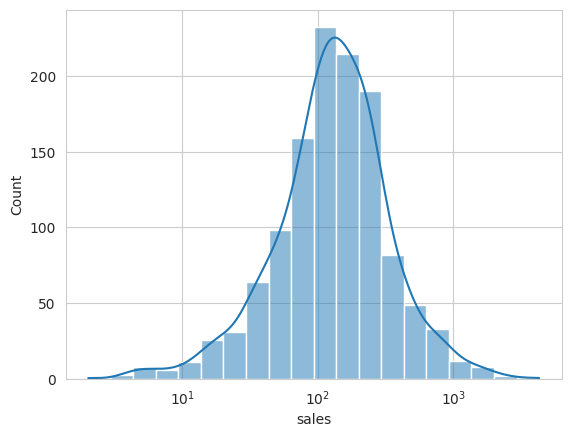

In [24]:
sns.histplot(data=avg_sales, x='sales', bins=20, log_scale=True, kde=True)
plt.show()

In [25]:
avg_sales['sales_log'] = np.log(avg_sales['sales'])
avg_sales['sales_log'] = iqr_outliers(avg_sales['sales_log'])

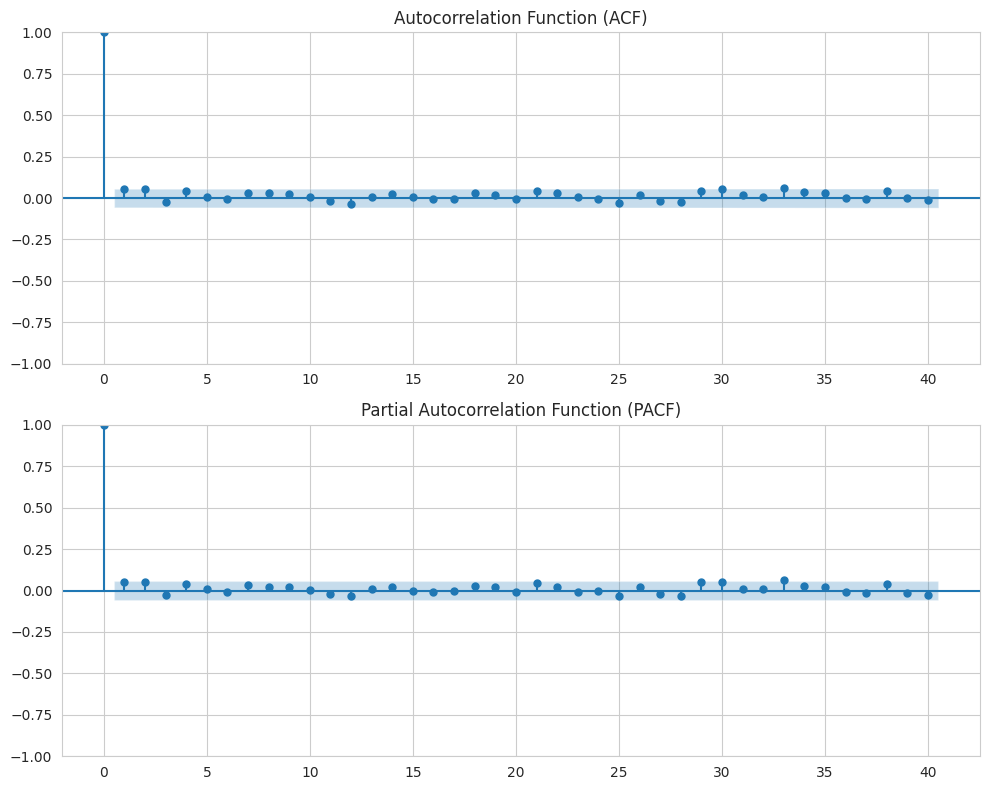

In [26]:
plot_acf_pacf(avg_sales['sales_log'])

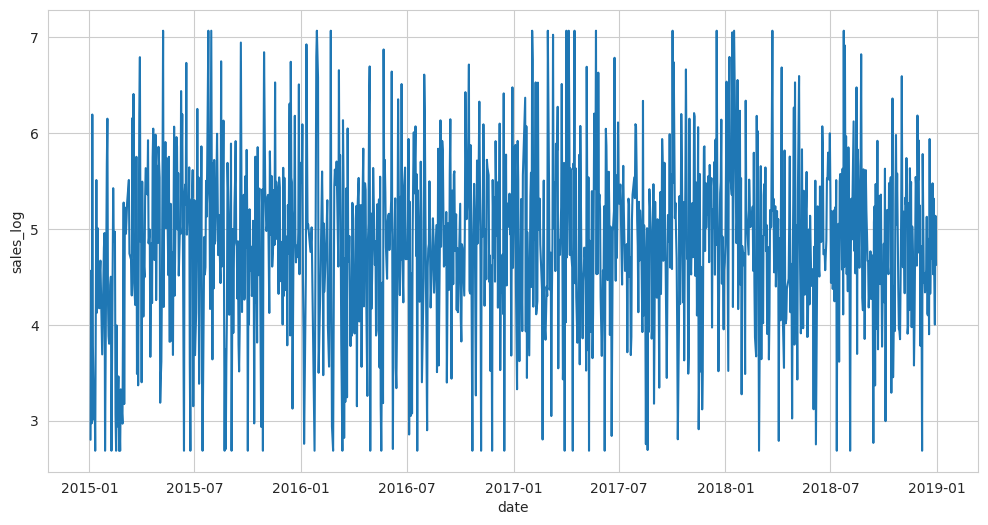

In [28]:
plt.figure(figsize=(12,6))
sns.lineplot(data=avg_sales, x='date', y='sales_log')
plt.show()

### Model Building

#### ARIMA

In [33]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Split data into training and testing sets
train_data = avg_sales['sales_log'][:-30]
test_data = avg_sales['sales_log'][-30:]


p = 30
q = 0
d = 1
sales_model = ARIMA(train_data, order=(p, d, q))
sales_model_fit = sales_model.fit()

# predictions on the test set
predictions = sales_model_fit.predict(start=len(train_data), end=len(avg_sales['sales_log']) - 1)

# predict on training data
train_predictions = sales_model_fit.predict(start=0, end=len(train_data) - 1)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(test_data, predictions))

# train rmse
train_rmse = np.sqrt(mean_squared_error(train_data, train_predictions))

print('Train RMSE: %.3f' % train_rmse)
print('Test RMSE: %.3f' % rmse)

Train RMSE: 0.927
Test RMSE: 0.729


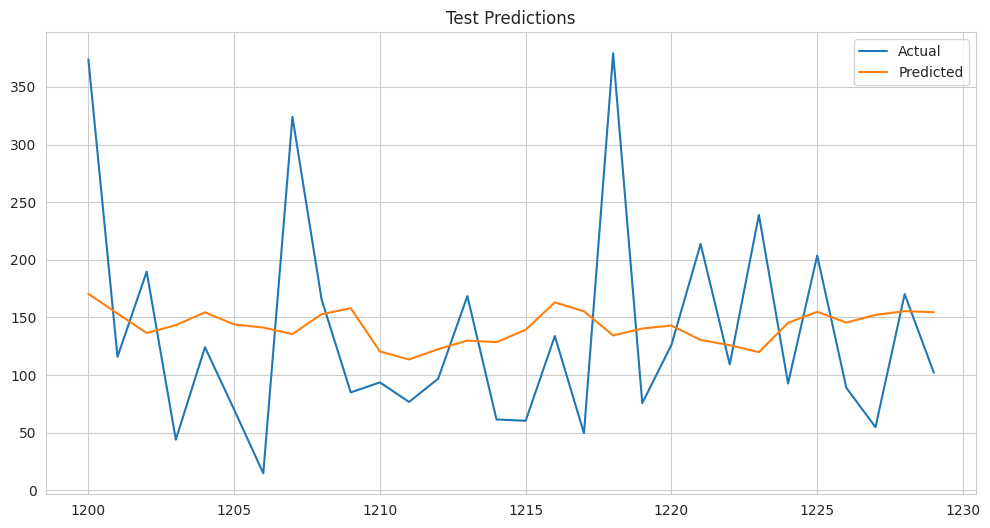

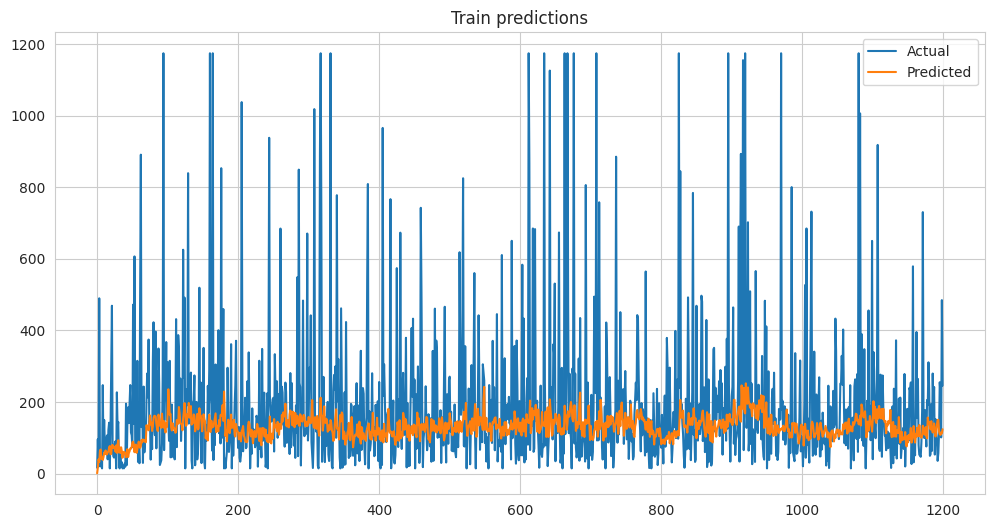

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, np.exp(test_data), label='Actual')
plt.plot(test_data.index, np.exp(predictions), label='Predicted')
plt.legend()
plt.title('Test Predictions')
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(train_data.index, np.exp(train_data), label='Actual')
plt.plot(train_data.index, np.exp(train_predictions), label='Predicted')
plt.legend()
plt.title('Train predictions')
plt.show()


In [35]:
np.exp(sales_model_fit.forecast(steps = 30))

1200    170.389525
1201    153.284560
1202    136.399358
1203    143.214131
1204    154.333609
1205    143.852177
1206    141.172092
1207    135.469436
1208    152.698096
1209    157.957522
1210    120.400146
1211    113.436375
1212    122.443121
1213    129.859534
1214    128.446124
1215    139.195925
1216    162.998326
1217    155.239958
1218    134.303491
1219    140.267791
1220    142.918664
1221    130.411039
1222    125.806427
1223    119.784543
1224    145.202870
1225    154.819889
1226    145.435597
1227    152.132255
1228    155.376068
1229    154.449519
Name: predicted_mean, dtype: float64

In [36]:
num_sales = store_df.groupby(by=['Order Date'])['Order ID'].count().reset_index().rename(
    columns = {'Order ID': 'num_sales', 'Order Date': 'date'}
)
num_sales.head()

date  num_sales
0 2015-01-03          1
1 2015-01-04          3
2 2015-01-05          1
3 2015-01-06          9
4 2015-01-07          2

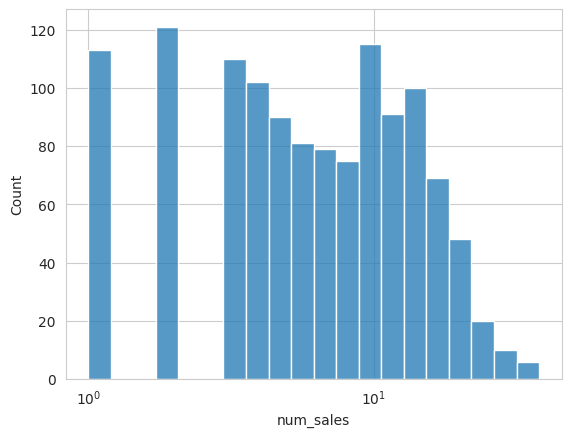

In [37]:
sns.histplot(data=num_sales, x='num_sales', log_scale=True, bins=20)
plt.show()

In [38]:
num_sales['num_sales_log'] = np.log(num_sales['num_sales'])
num_sales['num_sales_log'] = iqr_outliers(num_sales['num_sales_log'])

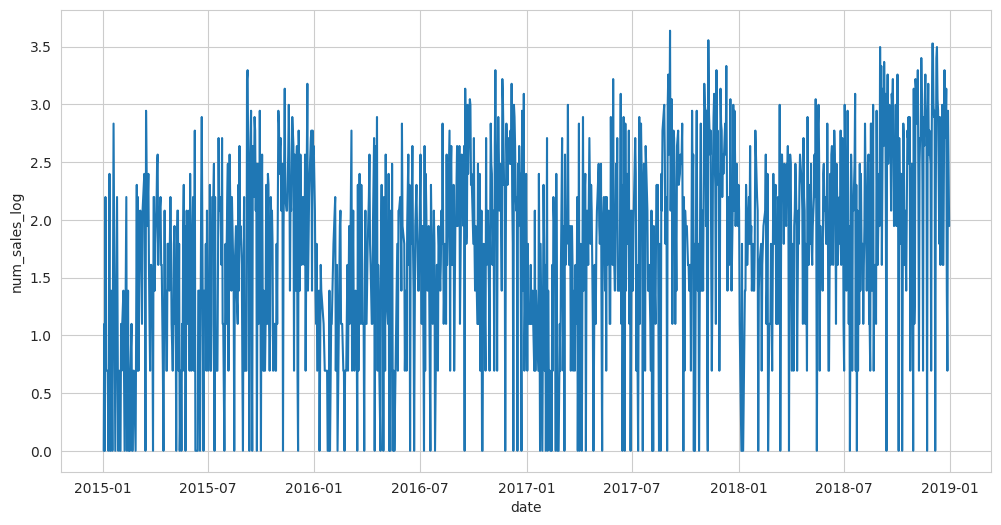

In [39]:
plt.figure(figsize=(12,6))
sns.lineplot(data=num_sales, x='date', y='num_sales_log')
plt.show()

In [40]:
is_stationary(num_sales['num_sales_log'])

True

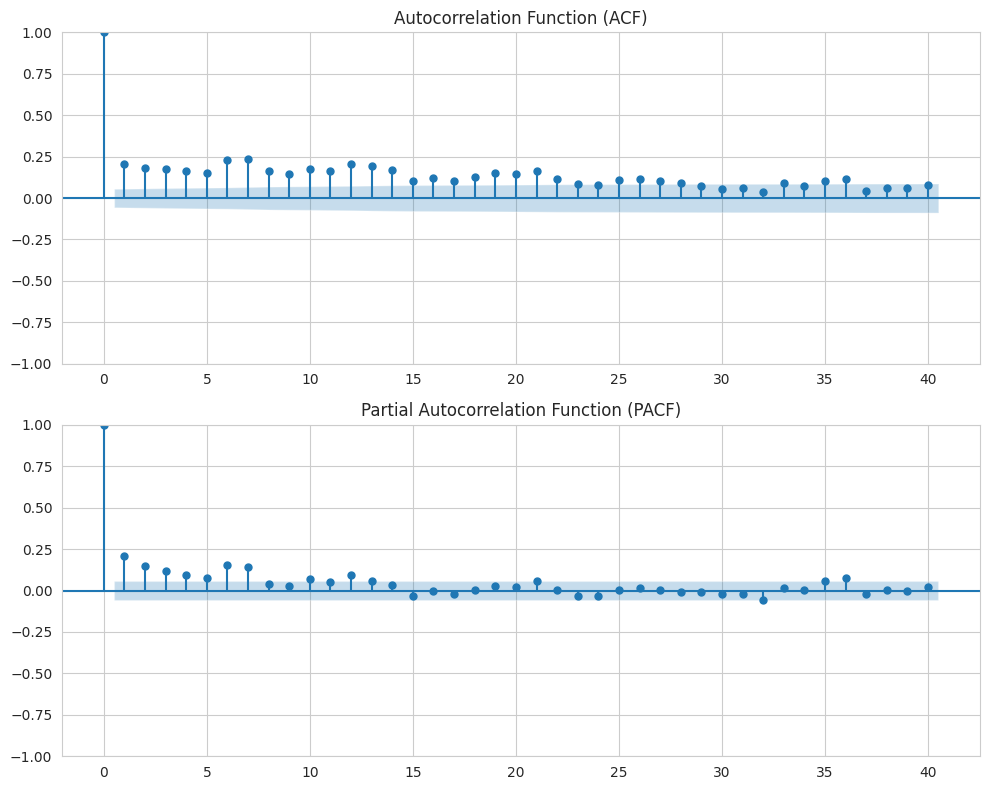

In [41]:
plot_acf_pacf(num_sales['num_sales_log'])

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train RMSE: 0.807
Test RMSE: 0.773


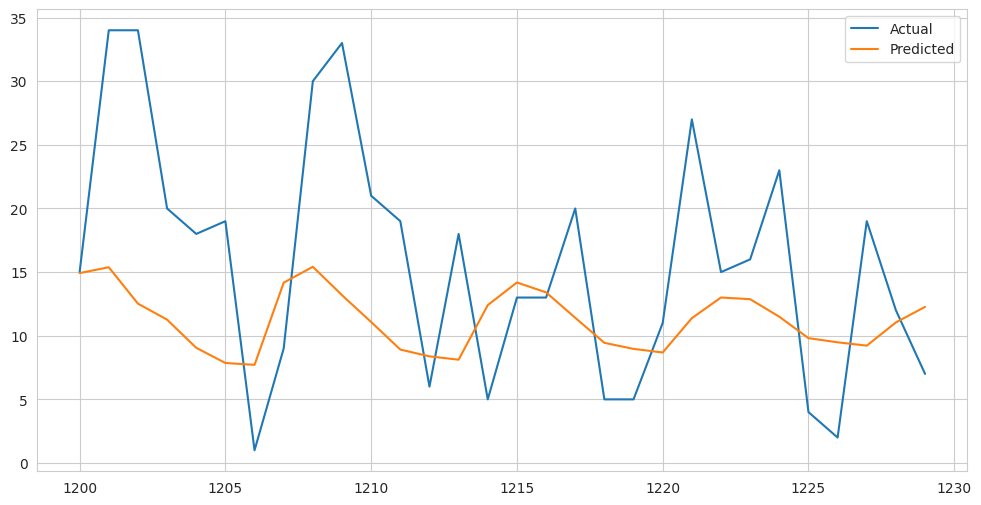

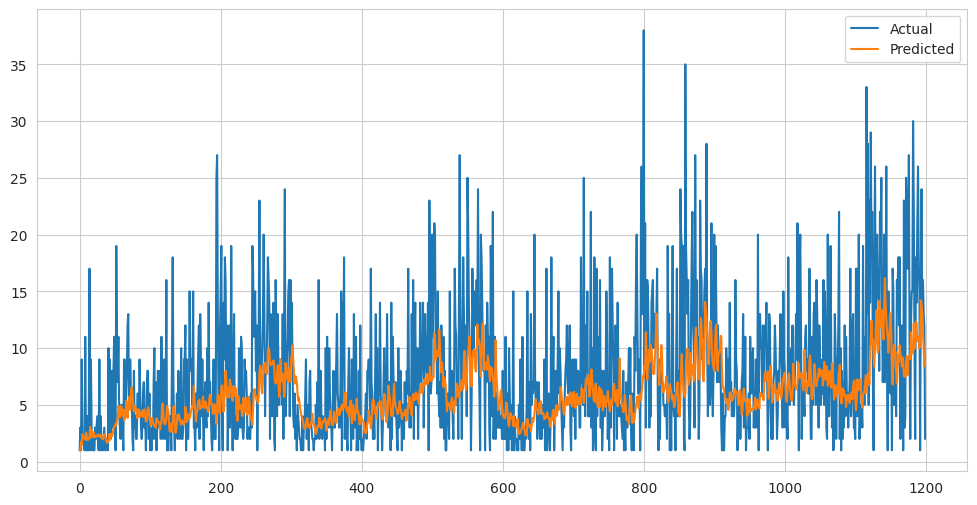

In [42]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

attr = 'num_sales_log'

# Split data into training and testing sets
train_data = num_sales[attr][:-30]
test_data = num_sales[attr][-30:]


p = 10
d = 1
q = 10
num_sales_model_arima = ARIMA(train_data, order=(p, d, q))
num_sales_model_arima_fit = num_sales_model_arima.fit()

# Make predictions on the test set
predictions = num_sales_model_arima_fit.predict(start=len(train_data), end=len(num_sales[attr]) - 1)

# predict on training data
train_predictions = num_sales_model_arima_fit.predict(start=0, end=len(train_data) - 1)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(test_data, predictions))

# train rmse
train_rmse = np.sqrt(mean_squared_error(train_data, train_predictions))

print('Train RMSE: %.3f' % train_rmse)
print('Test RMSE: %.3f' % rmse)

#Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, np.exp(test_data), label='Actual')
plt.plot(test_data.index, np.exp(predictions), label='Predicted')
plt.legend()
plt.show()


# plot train predictions
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, np.exp(train_data), label='Actual')
plt.plot(train_data.index, np.exp(train_predictions), label='Predicted')
plt.legend()
plt.show()


In [43]:
np.exp(num_sales_model_fit.forecast(steps=20))

1200    14.921951
1201    15.380814
1202    12.523139
1203    11.262638
1204     9.052072
1205     7.857773
1206     7.712040
1207    14.170244
1208    15.418075
1209    13.187372
1210    11.077854
1211     8.913421
1212     8.379150
1213     8.118796
1214    12.405414
1215    14.184081
1216    13.407733
1217    11.410287
1218     9.441866
1219     8.965855
Name: predicted_mean, dtype: float64

Correlation between num_sales_log and avg_sales_log: 0.14945177169500684


Text(0, 0.5, 'sales_log')

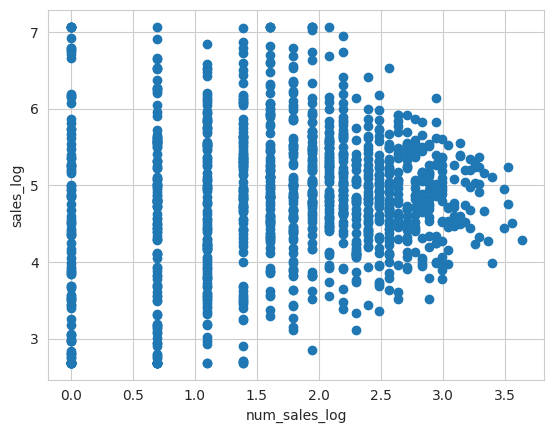

In [44]:

sales_df = pd.merge(num_sales, avg_sales, on='date', how='inner')

# Calculate the correlation
correlation = sales_df['num_sales_log'].corr(sales_df['sales_log'])
print(f"Correlation between num_sales_log and avg_sales_log: {correlation}")

# scatter plot
plt.scatter(sales_df['num_sales_log'], sales_df['sales_log'])
plt.xlabel('num_sales_log')
plt.ylabel('sales_log')

There isn't much correlation between number of sales and average sales

#### LSTM Model

In [45]:

sequence_length = 10
forecast_length = 1

sales_data = sales_df['num_sales_log'].values

X, y = create_sequences(sales_df, sequence_length, forecast_length, ['num_sales_log'], ['num_sales_log'])

y = np.squeeze(y, 1)
print("Sequences shape:", X.shape)
print("Targets shape:", y.shape)

Sequences shape: (1220, 10, 1)
Targets shape: (1220, 1)


In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(976, 10, 1) (244, 10, 1) (976, 1) (244, 1)


In [47]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

print(X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape)

torch.Size([976, 10, 1]) torch.Size([976, 1]) torch.Size([244, 10, 1]) torch.Size([244, 1])


In [56]:

class SalesLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SalesLSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
             nn.ReLU(),
             nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


input_size = 1
hidden_size = 10
num_layers = 1
output_size = 1

sales_lstm_model = SalesLSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(sales_lstm_model.parameters(), lr=0.001)


In [57]:
num_sales_lstm_results = lstm_training(sales_lstm_model, criterion, optimizer, 
              X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
              batch_size =16, num_epochs = 200)

Epoch [1/200], Loss: 2.9940, Test Loss: 2.4679
Epoch [2/200], Loss: 1.6238, Test Loss: 1.1662
Epoch [3/200], Loss: 0.8514, Test Loss: 0.7662
Epoch [4/200], Loss: 0.7510, Test Loss: 0.7378
Epoch [5/200], Loss: 0.7498, Test Loss: 0.7411
Epoch [6/200], Loss: 0.7476, Test Loss: 0.7424
Epoch [7/200], Loss: 0.7436, Test Loss: 0.7417
Epoch [8/200], Loss: 0.7344, Test Loss: 0.7341
Epoch [9/200], Loss: 0.7324, Test Loss: 0.7949
Epoch [10/200], Loss: 0.7306, Test Loss: 0.7655
Epoch [11/200], Loss: 0.7587, Test Loss: 0.9008
Epoch [12/200], Loss: 0.7367, Test Loss: 0.7306
Epoch [13/200], Loss: 0.7669, Test Loss: 0.7910
Epoch [14/200], Loss: 0.7376, Test Loss: 0.7223
Epoch [15/200], Loss: 0.7385, Test Loss: 0.7910
Epoch [16/200], Loss: 0.7203, Test Loss: 0.7243
Epoch [17/200], Loss: 0.7415, Test Loss: 0.8289
Epoch [18/200], Loss: 0.7307, Test Loss: 0.7325
Epoch [19/200], Loss: 0.7644, Test Loss: 0.7972
Epoch [20/200], Loss: 0.7315, Test Loss: 0.7223
Epoch [21/200], Loss: 0.7366, Test Loss: 0.7962
E

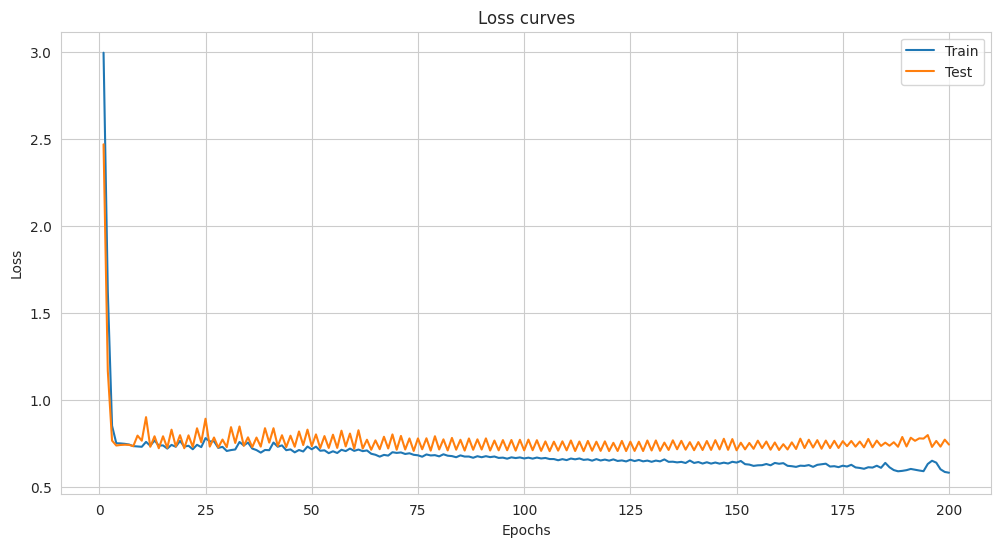

In [58]:
plot_losses(num_sales_lstm_results)

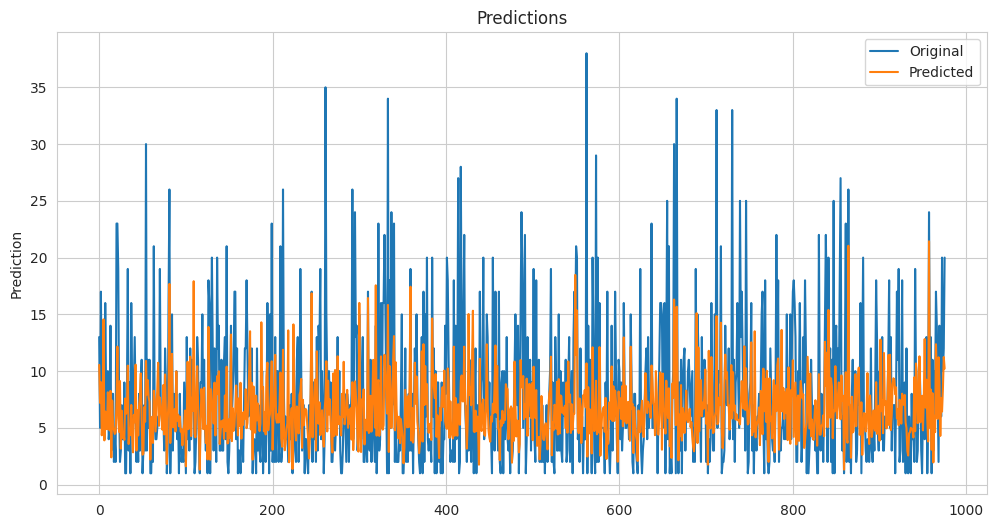

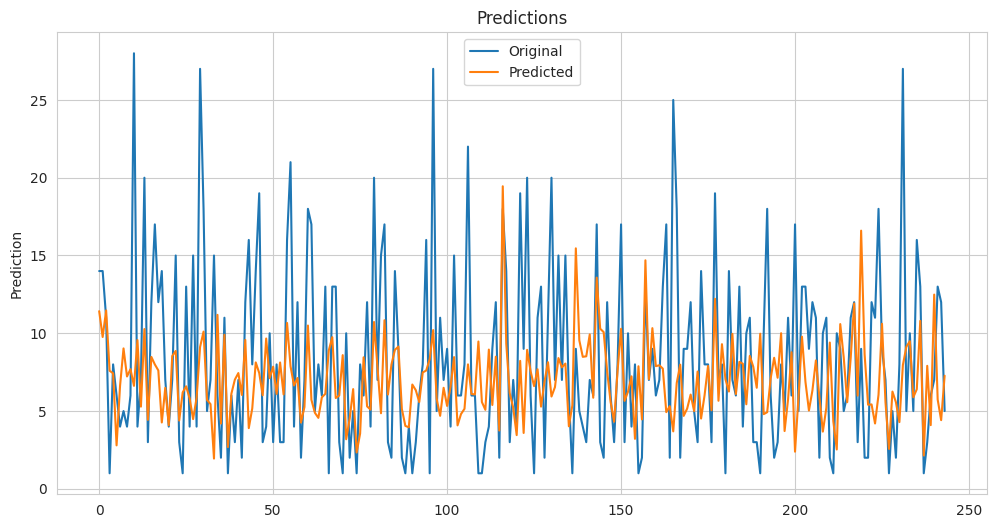

In [66]:
sales_lstm_model.eval()

with torch.no_grad():

  y_test_pred = sales_lstm_model(X_test_tensor).detach().numpy()
  y_train_pred = sales_lstm_model(X_train_tensor).detach().numpy()

plot_predictions(np.exp(y_train), np.exp(y_train_pred))
plot_predictions(np.exp(y_test), np.exp(y_test_pred))

### XGBoost Model

Train RMSE: 0.001782243930400121, Test RMSE: 0.8973835479145017


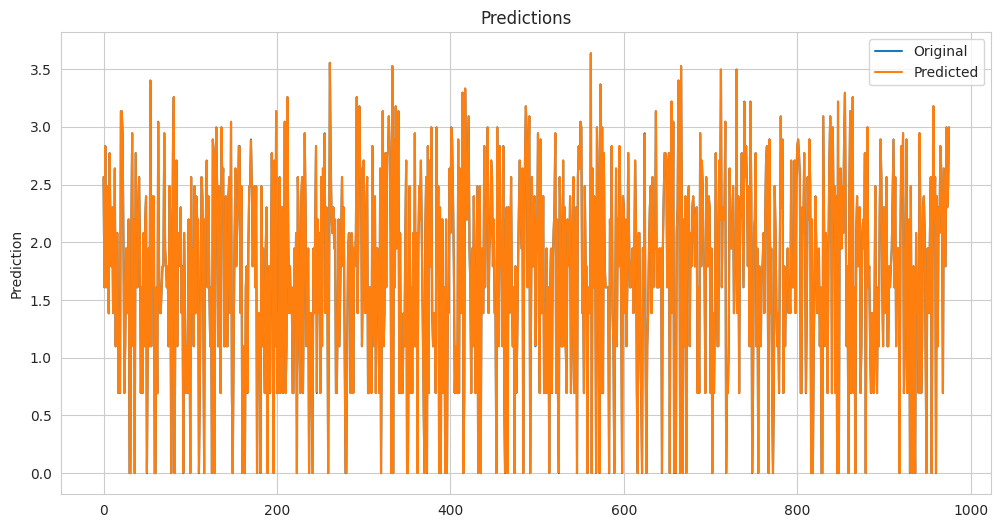

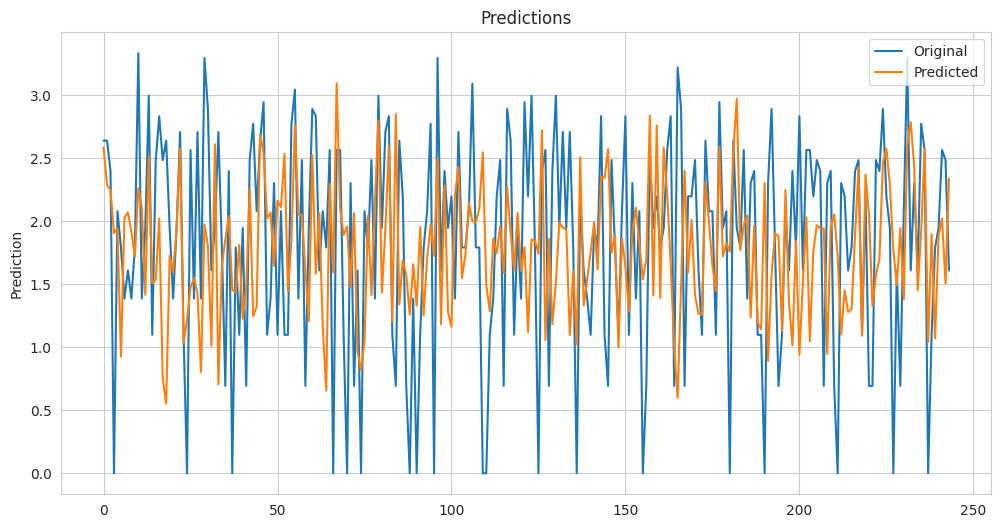

In [70]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Reshape the data for XGBoost
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)

# Initialize the XGBoost regressor
num_sales_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    random_state=42)

train_preds, test_preds = xgb_train(num_sales_xgb_model, X_train_xgb, y_train, X_test_xgb, y_test)


plot_predictions(y_train, train_preds)
plot_predictions(y_test, test_preds)


#### Predictions

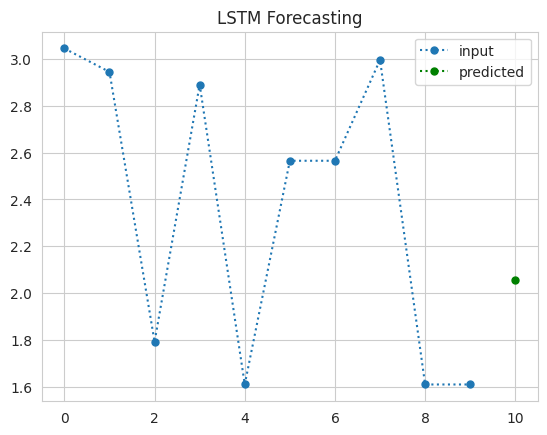

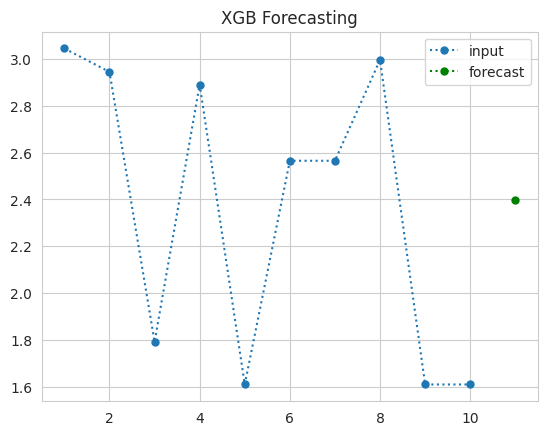

In [109]:
inputs = sales_df['num_sales_log'].iloc[-20:-10].to_numpy()
lstm_forecast(sales_lstm_model, inputs)
xgb_forecast(num_sales_xgb_model, inputs)

In [ ]:
torch.save(sales_lstm_model.state_dict(), "sales_lstm_model.pth")
num_sales_lstm_results.to_csv('num_sales_lstm_results.csv', index=False)
joblib.dump(num_sales_xgb_model, "num_sales_xgb_model.joblib")
joblib.dump(num_sales_model_arima_fit, "num_sales_model_arima_fit.joblib")
joblib.dump(sales_model_fit, "sales_model_fit.joblib")

## Delhi Weather

### Reading Data

In [57]:
climate_path_test = os.path.join(climate_path, "DailyDelhiClimateTest.csv")
climate_path_train = os.path.join(climate_path, "DailyDelhiClimateTrain.csv")

climate_train_df = pd.read_csv(climate_path_train, parse_dates = ['date'], index_col='date')
climate_test_df = pd.read_csv(climate_path_test, parse_dates = ['date'], index_col='date' )


climate_train_df.rename(columns = {'meantemp':'temp'} , inplace = True)
climate_test_df.rename(columns =  {'meantemp':'temp'} , inplace = True)

In [58]:
climate_train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp          1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [59]:
climate_test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2017-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp          114 non-null    float64
 1   humidity      114 non-null    float64
 2   wind_speed    114 non-null    float64
 3   meanpressure  114 non-null    float64
dtypes: float64(4)
memory usage: 4.5 KB


### EDA

In [60]:
df_info = pd.concat([climate_train_df.isna().sum() , climate_train_df.dtypes] , axis = 1)
df_info.columns = ['missing'  , 'dtype']
df_info

missing    dtype
temp                0  float64
humidity            0  float64
wind_speed          0  float64
meanpressure        0  float64

In [62]:
# no duplicates
climate_train_df[climate_train_df.duplicated()].sum()

temp            0.0
humidity        0.0
wind_speed      0.0
meanpressure    0.0
dtype: float64

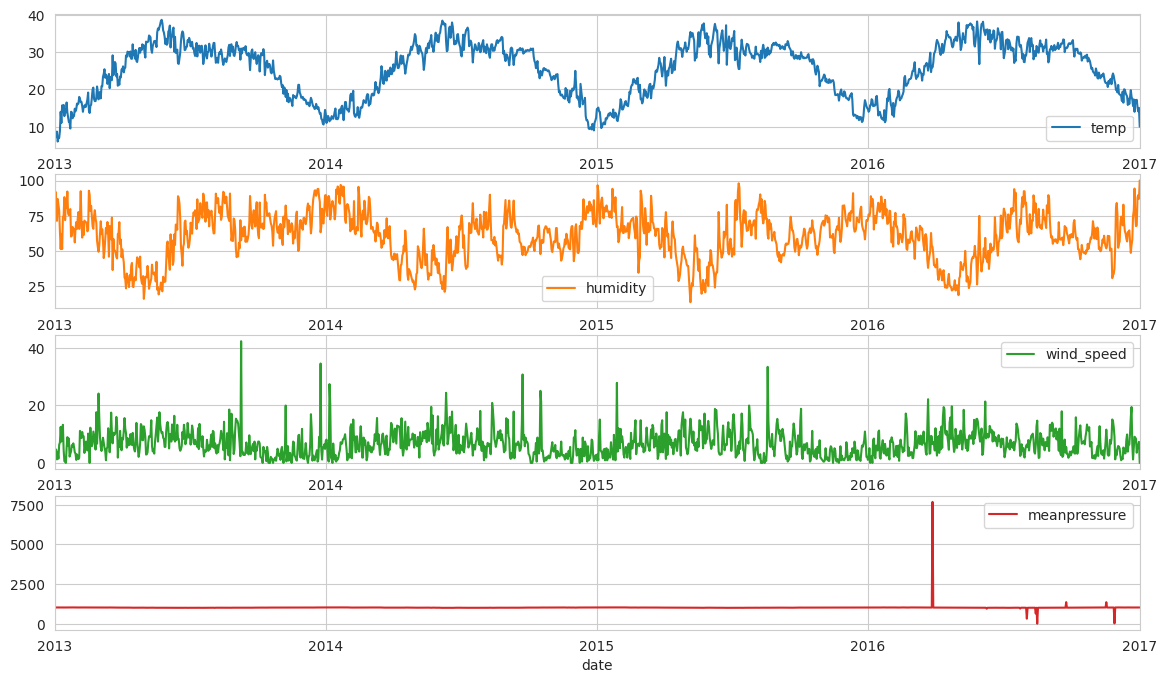

In [64]:
climate_train_df.plot(subplots = True,
           layout = (4,1),
           figsize = (14,8),
           sharex= False)

plt.show()

**it is obvious , there is yearly seasonal , and there is anomoly in mean pressure**

In [66]:
climate_train_df['meanpressure'].describe()

count    1462.000000
mean     1011.104548
std       180.231668
min        -3.041667
25%      1001.580357
50%      1008.563492
75%      1014.944901
max      7679.333333
Name: meanpressure, dtype: float64

**Typical atmospheric range is around: 965 to 1040**

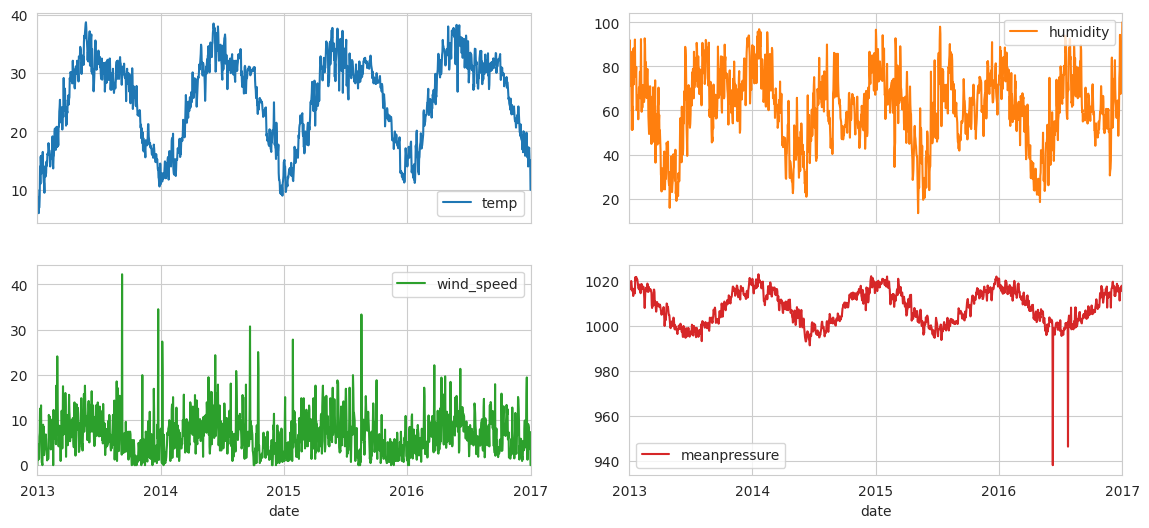

In [69]:
climate_train_errors = climate_train_df[(climate_train_df['meanpressure'] < 900) | (climate_train_df['meanpressure']>1083)]
train_cleaned = climate_train_df.drop(climate_train_errors.index , axis = 0)
mean_pressure_modified = train_cleaned['meanpressure'].mean()
climate_train_df.loc[climate_train_errors.index , 'meanpressure'] = mean_pressure_modified
climate_train_df.plot(subplots = True , layout = (2,2) , figsize = (14,6))
plt.show()

Text(0.5, 1.0, 'mean pressure after cleaning')

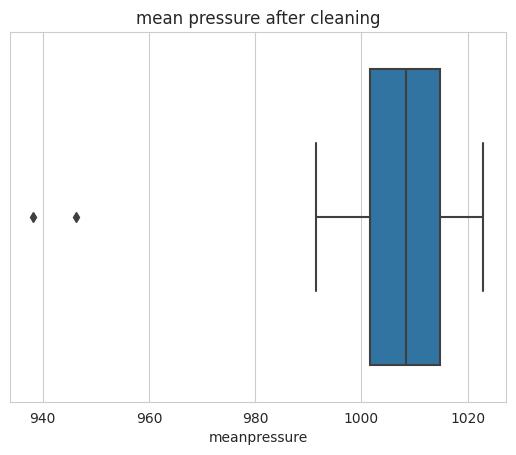

In [70]:
sns.boxplot(climate_train_df , x = 'meanpressure')
plt.title('mean pressure after cleaning')

In [71]:
train_weekly = climate_train_df.resample('W').mean()
train_monthly = climate_train_df.resample('ME').mean()

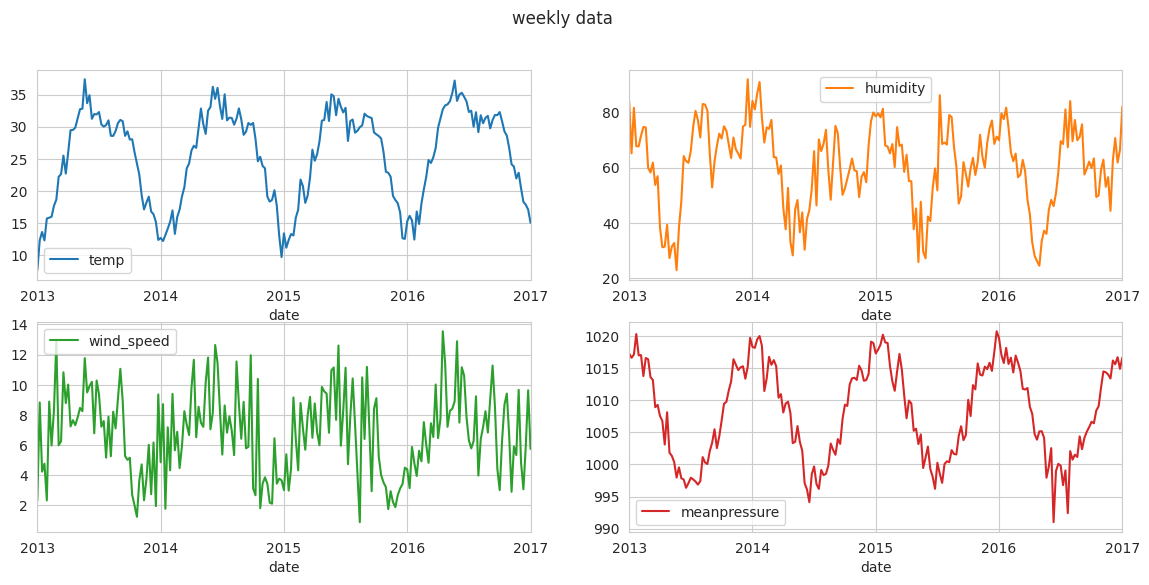

In [72]:
train_weekly.plot(subplots = True,
                  layout = (2,2),
                  figsize = (14,6),
                  title = 'weekly data',
                  sharex=False)

plt.show()

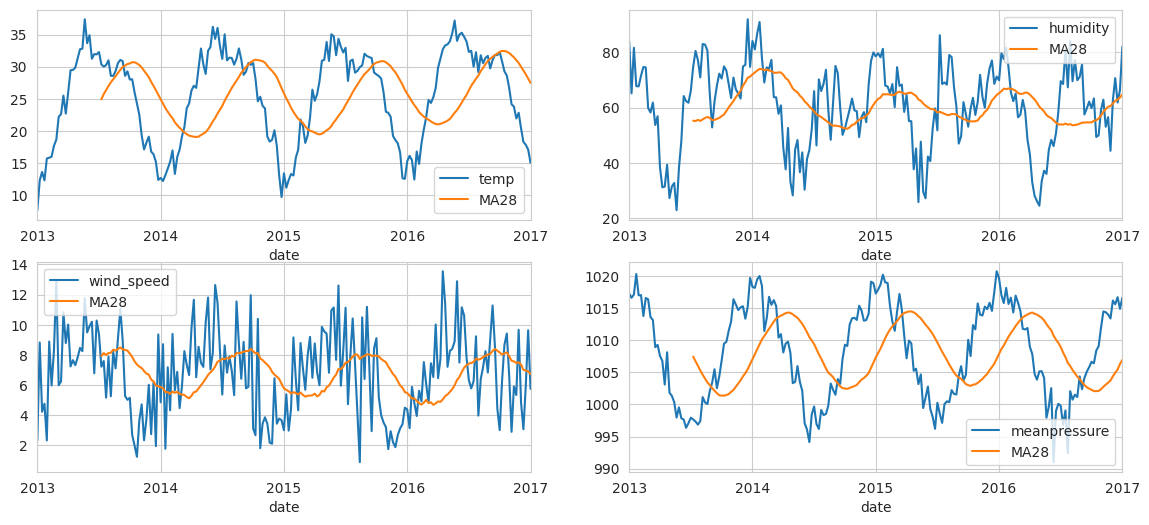

In [73]:
MA28 = train_weekly.rolling(window=28).mean()

fig , ax = plt.subplots(nrows = 2 , ncols=2 ,figsize = (14,6))

for ax , col in zip(ax.flat , climate_train_df.columns):
    train_weekly[col].plot(ax = ax , legend = col)
    MA28[col].plot(ax = ax  , label = 'MA28')
    ax.legend()

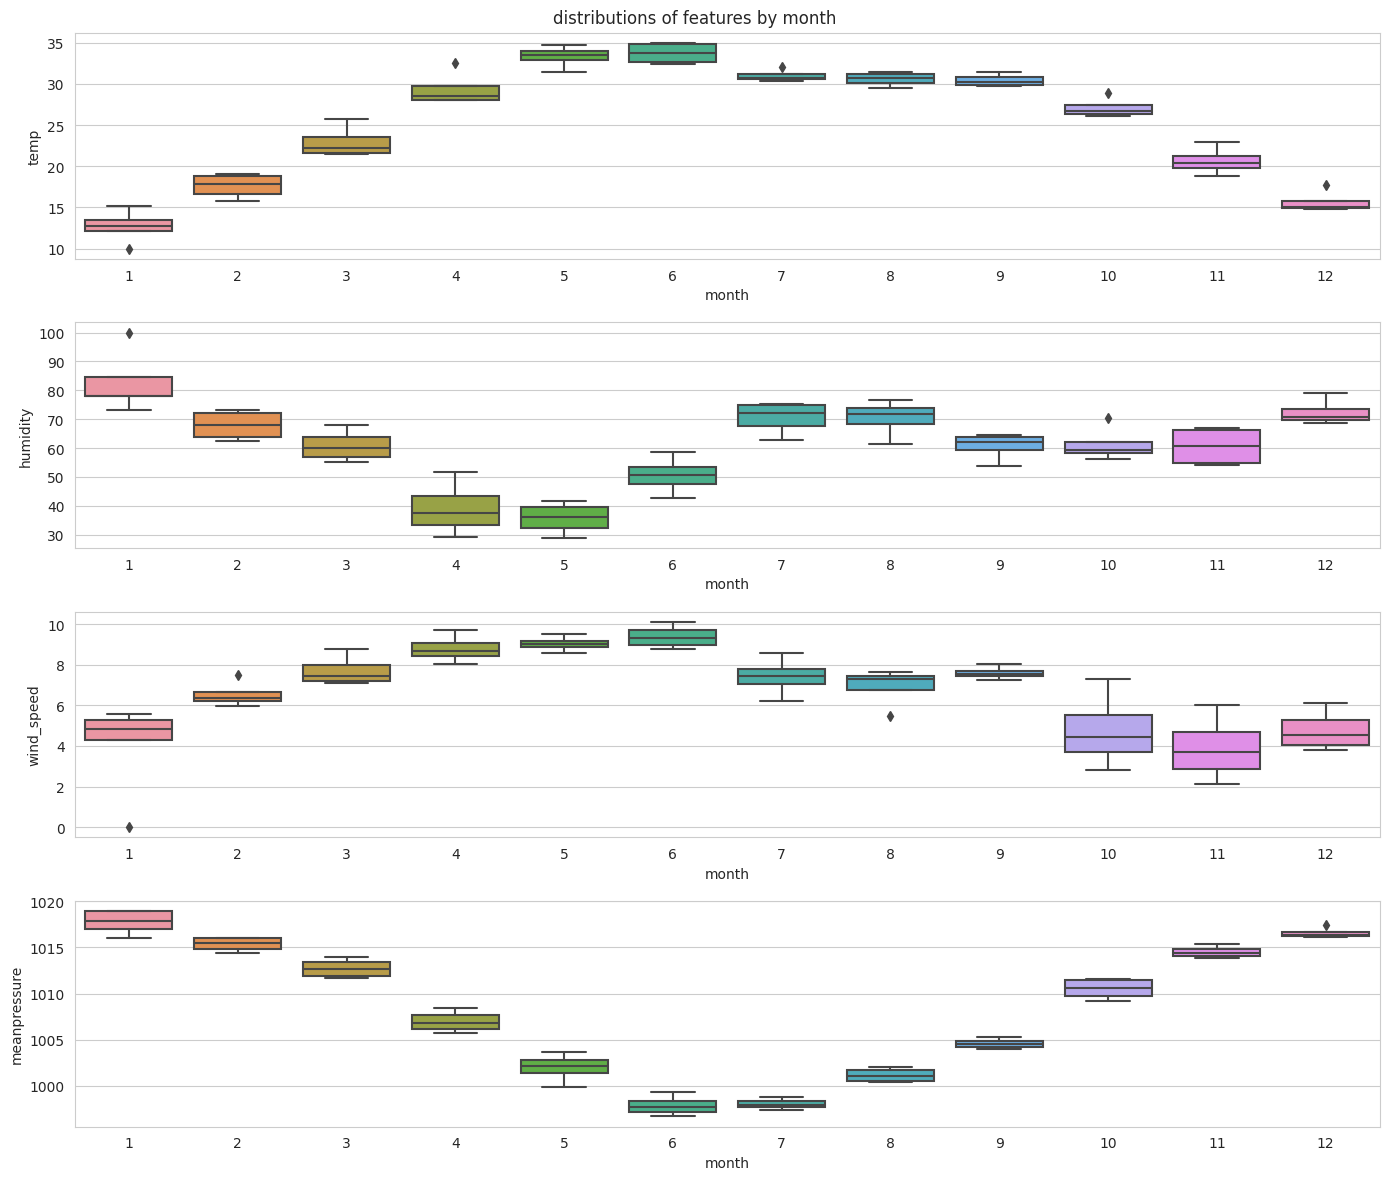

In [74]:
fig , ax = plt.subplots(4,1,figsize = (14,12) )

for ax , col in zip(ax.flat , climate_train_df.columns):
    sns.boxplot(train_monthly , y = col , x=train_monthly.index.month  , ax = ax)
    ax.set_xlabel('month')

fig.suptitle('distributions of features by month') , plt.tight_layout()
plt.show()

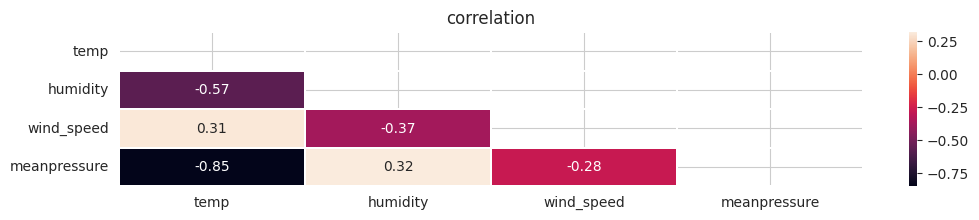

In [75]:
train_corr = climate_train_df.corr()
mask = np.tril(np.ones(train_corr.shape) , k = -1).astype(bool)
train_corr = train_corr.where(mask)


plt.figure(figsize = (12,2))
sns.heatmap(train_corr , annot =True ,linewidths=0.1) , plt.title('correlation')
plt.show()

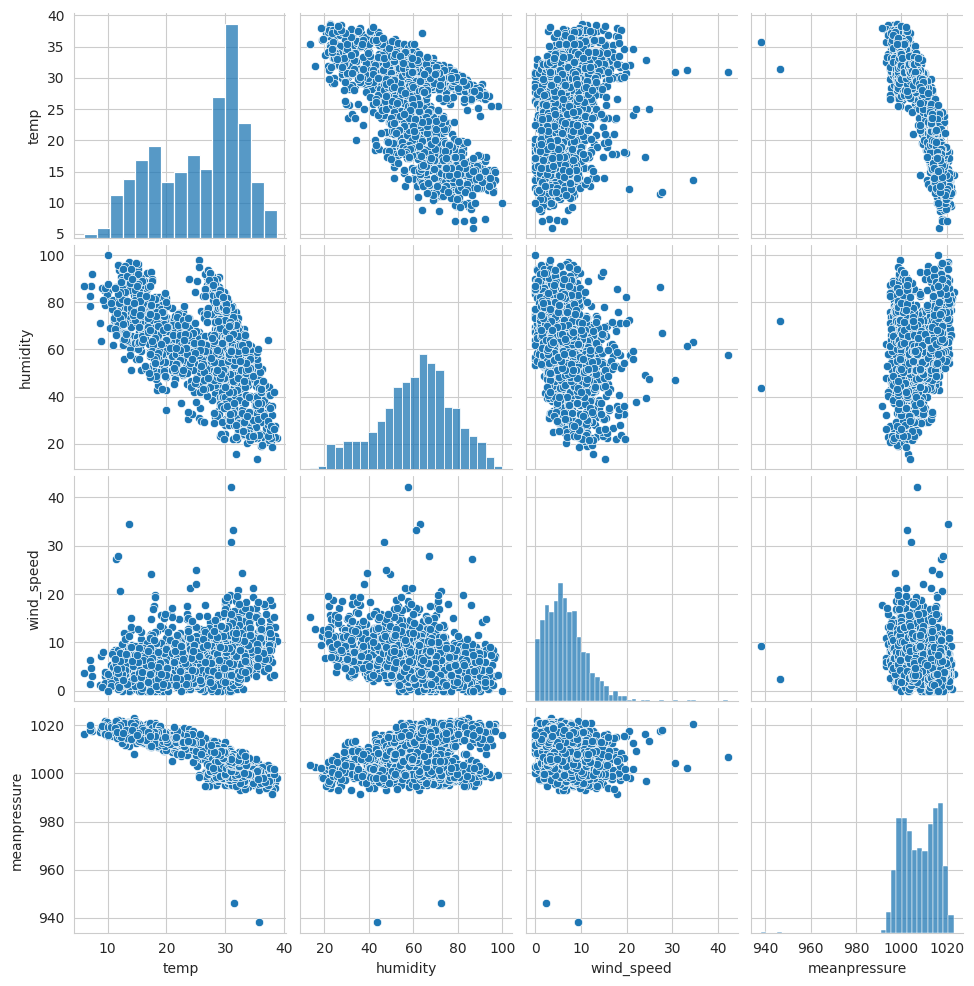

In [76]:
sns.pairplot(climate_train_df)
plt.show()

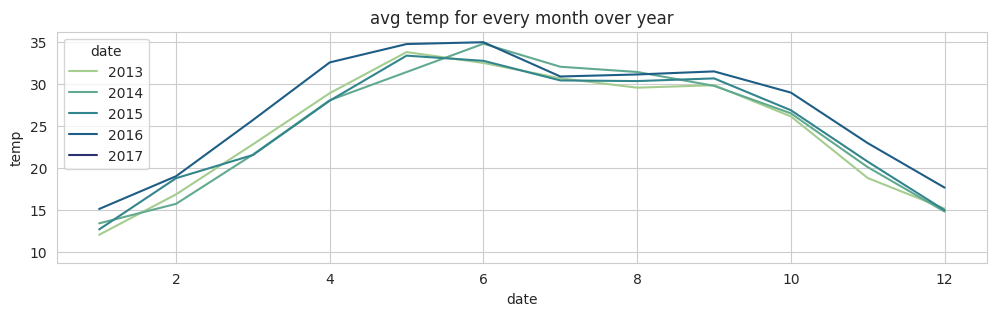

In [77]:
plt.figure(figsize = (12,3))
sns.lineplot(climate_train_df ,x = climate_train_df.index.month ,
             y = 'temp', 
             hue = climate_train_df.index.year ,
             palette='crest' , errorbar = None)
plt.title('avg temp for every month over year')
plt.show()

<Figure size 1400x600 with 0 Axes>

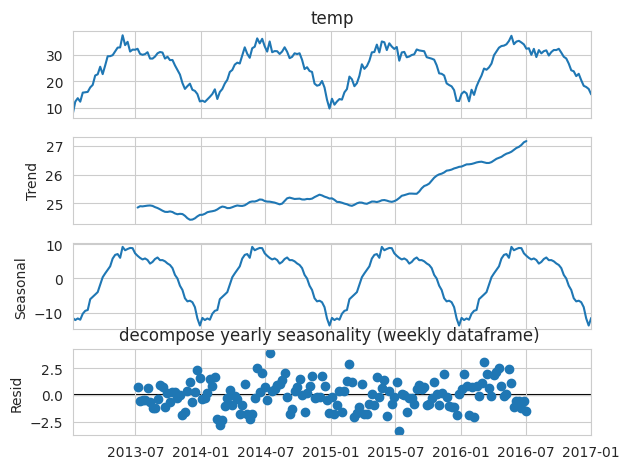

In [78]:
plt.figure(figsize=(14,6))
decompose_temp = sm.tsa.seasonal_decompose(train_weekly['temp'])
decompose_temp.plot()
plt.title('decompose yearly seasonality (weekly dataframe) ')

plt.show()

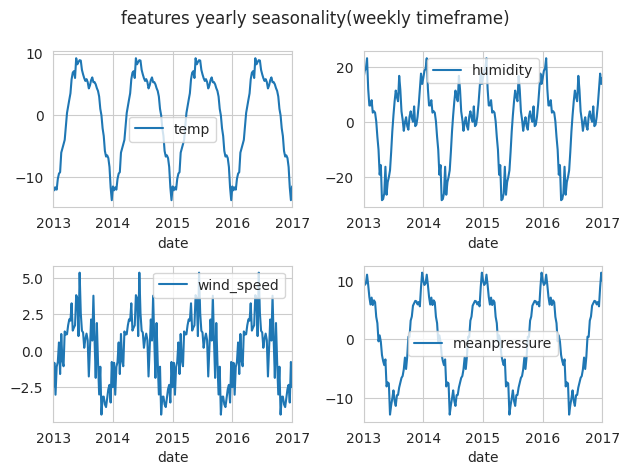

In [79]:
fig ,ax = plt.subplots(2,2)
for ax , col in zip(ax.flat , climate_train_df.columns):
    decompose= sm.tsa.seasonal_decompose(train_weekly[col])
    decompose.seasonal.plot(ax = ax , label = col)
    ax.legend()
    plt.tight_layout()
    plt.suptitle('features yearly seasonality(weekly timeframe)')

there is yearly seasonality for all feature ,wind speed seasonality is more noisier
check for weekly seasonality
important : we need to take smaller observation period, lets take 6 month we do this , because for all data , we can not visulize daily timeframe

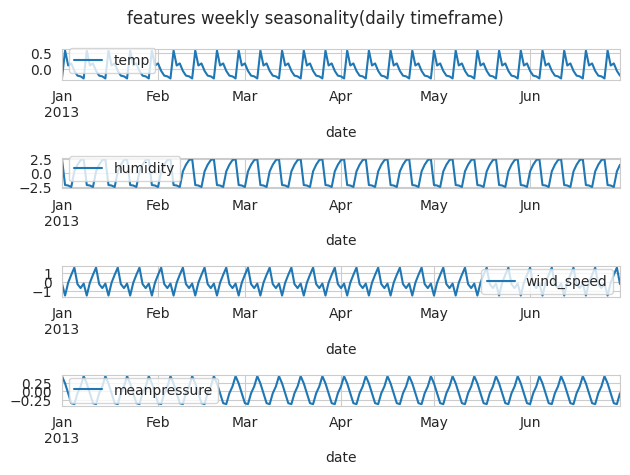

In [80]:
period = slice( '2013-01' ,'2013-06' )   # 6 month

fig ,ax = plt.subplots(4,1)    # order of subplots changed , to see wider observation
for ax , col in zip(ax.flat , climate_train_df.columns):
    decompose= sm.tsa.seasonal_decompose(climate_train_df[period][col])   # notice , it is daily data for 6 month
    decompose.seasonal.plot(ax = ax , label = col)
    ax.legend()
    plt.tight_layout()
    plt.suptitle('features weekly seasonality(daily timeframe)')

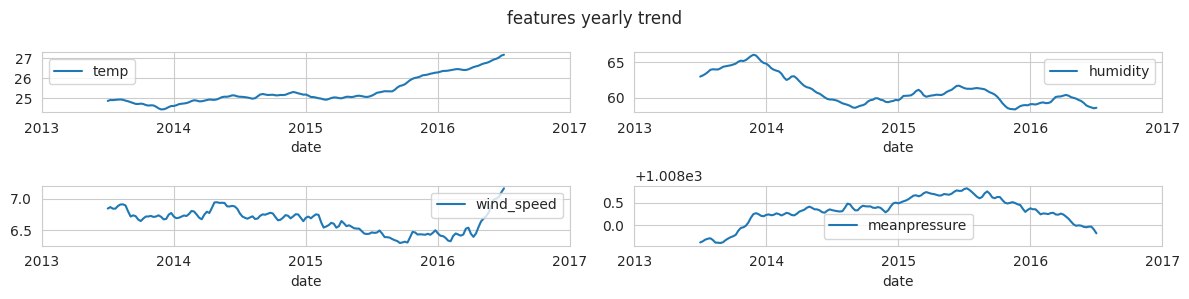

In [81]:
fig ,ax = plt.subplots(2,2 , figsize = (12,3))

for ax , col in zip(ax.flat , climate_train_df.columns):
    decompose= sm.tsa.seasonal_decompose(train_weekly[col])
    decompose.trend.plot(ax = ax , label = col)
    ax.legend()
    plt.tight_layout()
    plt.suptitle('features yearly trend')

### Model Building

In [86]:
from sklearn.preprocessing import StandardScaler

df_train = climate_train_df[:'2016-05'].copy(deep=True)
df_val = climate_train_df['2016-06':].copy(deep=True)    # almost 15% of train data set as validation set
df_test = climate_test_df.copy(deep=True)

climate_scaler = StandardScaler()
climate_scaler.fit(df_train)
df_train[:] = climate_scaler.transform(df_train)
df_val[:] = climate_scaler.transform(df_val)
df_test[:] = climate_scaler.transform(df_test)

seq_length = 28
forecast_length = 1
features = ['temp','meanpressure','wind_speed','humidity']
target_attrs = ['temp']

X_train, y_train = create_sequences(df_train, seq_length,
                                    forecast_length,
                                    features,
                                    target_attrs)

X_val, y_val = create_sequences(df_val, seq_length,
                                forecast_length, 
                                features,
                                target_attrs)

X_test, y_test = create_sequences(df_test, seq_length,
                                  forecast_length, features,
                                  target_attrs)


y_train = np.squeeze(y_train, 1)
y_val = np.squeeze(y_val, 1)
y_test = np.squeeze(y_test, 1)


print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

print(X_train_tensor.shape, 
      y_train_tensor.shape,
      X_val_tensor.shape,
      y_val_tensor.shape,
      X_test_tensor.shape,
      y_test_tensor.shape)


(1219, 28, 4) (1219, 1) (187, 28, 4) (187, 1)
torch.Size([1219, 28, 4]) torch.Size([1219, 1]) torch.Size([187, 28, 4]) torch.Size([187, 1]) torch.Size([86, 28, 4]) torch.Size([86, 1])


In [89]:
class ClimateModel(nn.Module):

  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super(ClimateModel, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    lstm_out, _ = self.lstm(x)
    out = self.linear(lstm_out[:, -1, :])
    return out

In [90]:
input_size = 4
hidden_size = 10
num_layers = 1
output_size= 1
learning_rate = 0.02
batch_size = 16
num_epochs = 100
climate_model = ClimateModel(input_size=input_size,
                  hidden_size=hidden_size,
                  output_size = output_size,
                  num_layers=num_layers).to(device)

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(climate_model.parameters(), lr=learning_rate)

climate_model

ClimateModel(
  (lstm): LSTM(4, 10, batch_first=True)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)

In [91]:
climate_results = lstm_training(climate_model,
              criterion,
              optimizer,
              X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, 
              batch_size, num_epochs)

Epoch [1/100], Loss: 0.7844, Test Loss: 0.4142
Epoch [2/100], Loss: 0.8749, Test Loss: 0.3856
Epoch [3/100], Loss: 0.4929, Test Loss: 0.2026
Epoch [4/100], Loss: 0.4676, Test Loss: 0.3034
Epoch [5/100], Loss: 0.2510, Test Loss: 0.3857
Epoch [6/100], Loss: 0.3205, Test Loss: 0.2772
Epoch [7/100], Loss: 0.3551, Test Loss: 0.2412
Epoch [8/100], Loss: 0.2943, Test Loss: 0.2842
Epoch [9/100], Loss: 0.2950, Test Loss: 0.2329
Epoch [10/100], Loss: 0.2931, Test Loss: 0.2523
Epoch [11/100], Loss: 0.3145, Test Loss: 0.2015
Epoch [12/100], Loss: 0.2950, Test Loss: 0.2511
Epoch [13/100], Loss: 0.2433, Test Loss: 0.2810
Epoch [14/100], Loss: 0.4301, Test Loss: 0.1481
Epoch [15/100], Loss: 0.1781, Test Loss: 0.1928
Epoch [16/100], Loss: 0.4017, Test Loss: 0.1600
Epoch [17/100], Loss: 0.5214, Test Loss: 0.5171
Epoch [18/100], Loss: 0.3410, Test Loss: 0.2449
Epoch [19/100], Loss: 0.4852, Test Loss: 0.3238
Epoch [20/100], Loss: 0.3176, Test Loss: 0.1953
Epoch [21/100], Loss: 1.0632, Test Loss: 1.2136
E

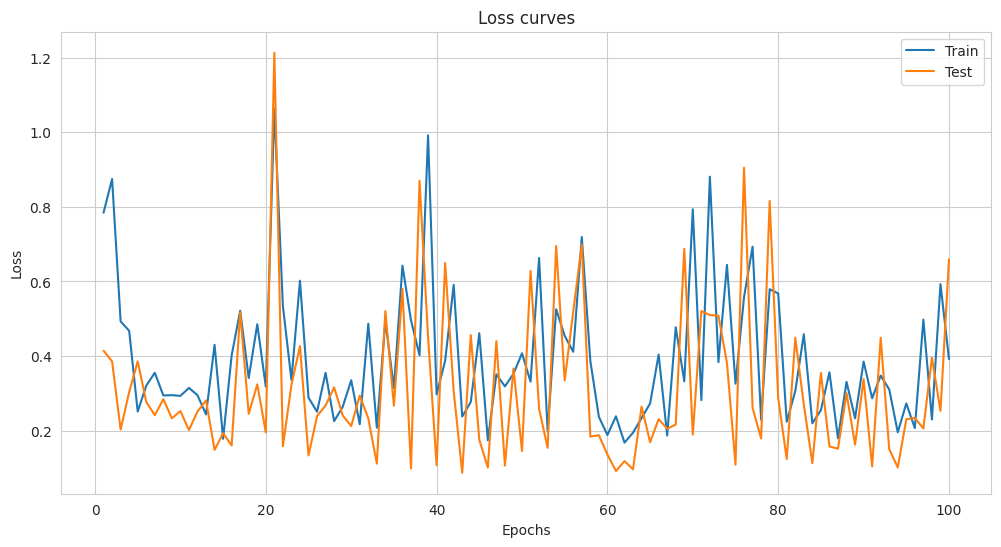

In [92]:
plot_losses(climate_results)

### Predictions

In [159]:
climate_model.eval()

with torch.no_grad():
    preds_train = climate_model(X_train_tensor).detach().cpu().numpy()
    preds_val = climate_model(X_val_tensor).detach().cpu().numpy()
    preds_test = climate_model(X_test_tensor).detach().cpu().numpy()


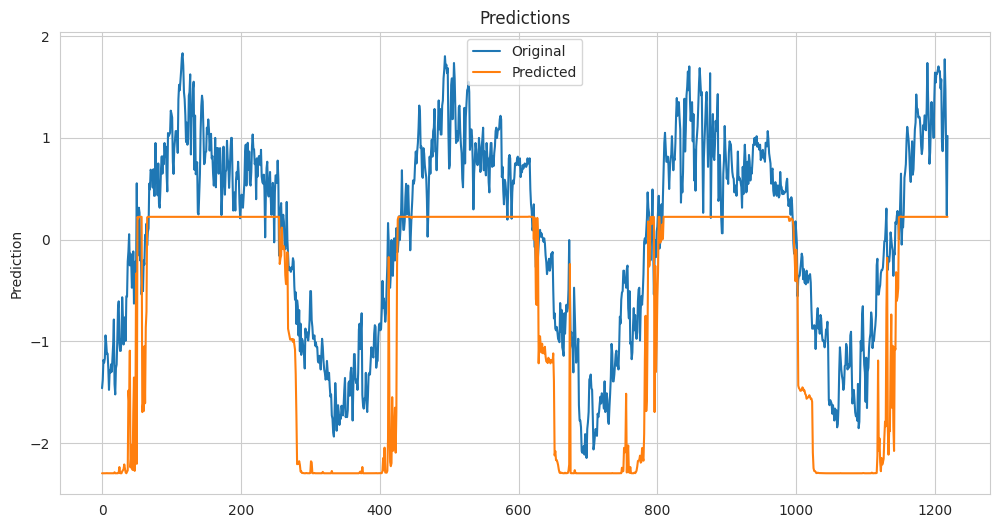

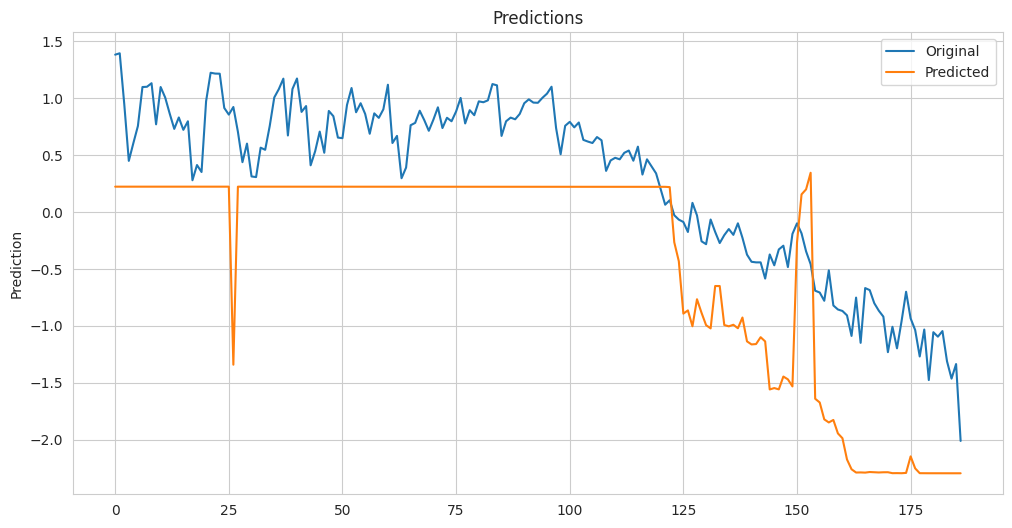

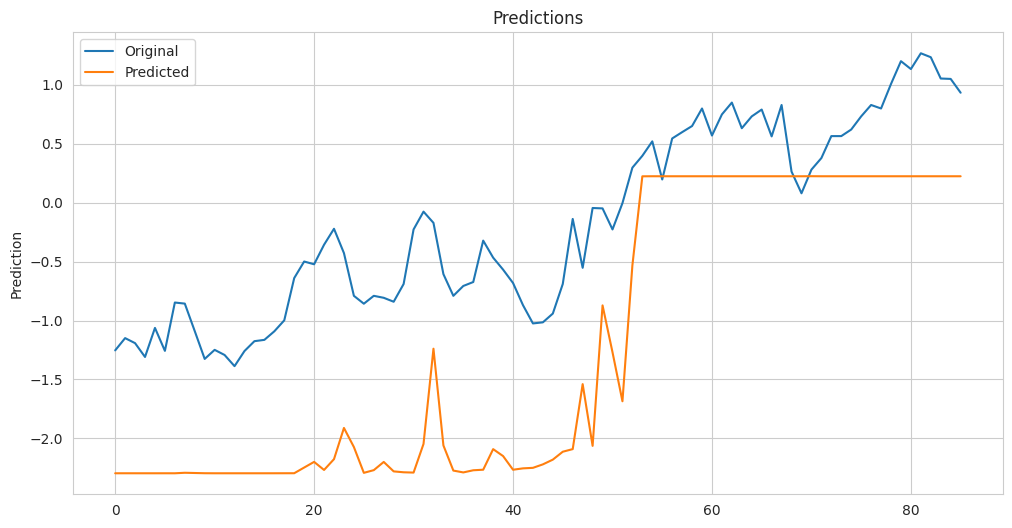

In [160]:

plot_predictions(y_train, preds_train)
plot_predictions(y_val, preds_val)
plot_predictions(y_test, preds_test)

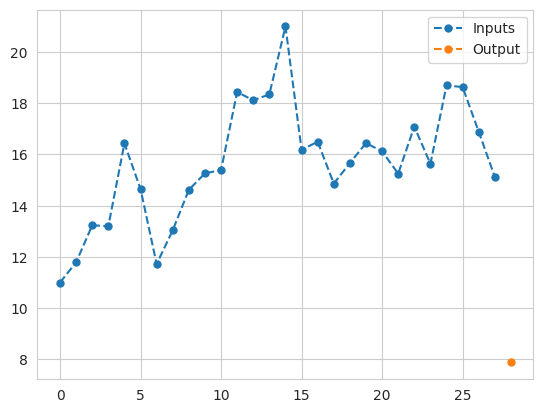

In [162]:
i = 10
    
inputs = climate_scaler.inverse_transform(X_test[i])
k = preds_test_tensor[i][0]
outputs = climate_scaler.inverse_transform([[k,k,k,k]])[:,0]


plt.plot(np.arange(28), inputs[:,0], label='Inputs', linestyle='--', marker='o', markersize=5)
plt.plot(np.arange(28,29), outputs, label='Output', linestyle='--', marker='o', markersize=5)
    
plt.legend()
plt.show()

### XGBoost Model

Train RMSE: 0.0005583706491053972, Test RMSE: 0.2190480734950793


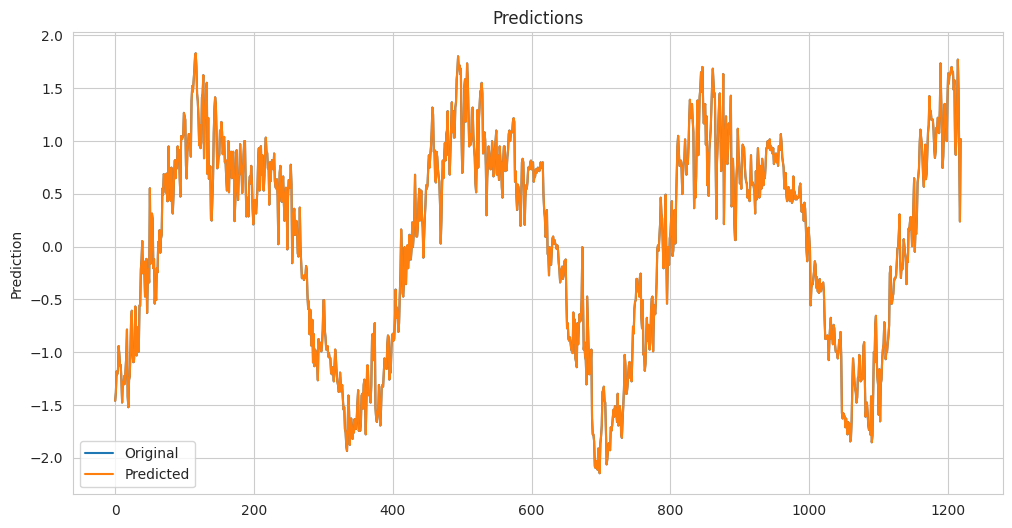

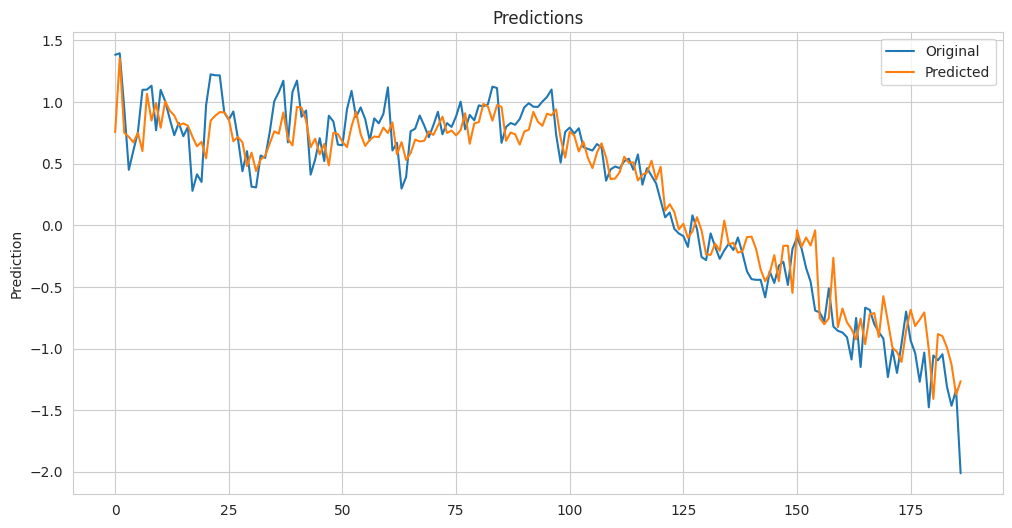

In [142]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Reshape the data for XGBoost
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_val_xgb = X_val.reshape(X_val.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)
# Initialize the XGBoost regressor
climate_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    random_state=42)

train_preds, val_preds = xgb_train(climate_xgb_model, X_train_xgb, y_train, X_val_xgb, y_val)


plot_predictions(y_train, train_preds)
plot_predictions(y_val, val_preds)


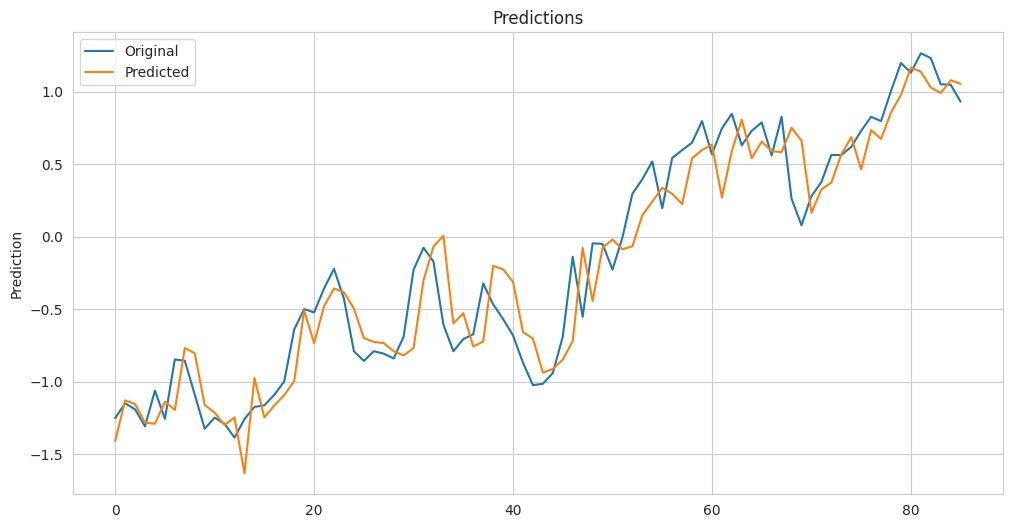

In [145]:
preds_test_xgb = climate_xgb_model.predict(X_test_xgb)
plot_predictions(y_test, preds_test_xgb)

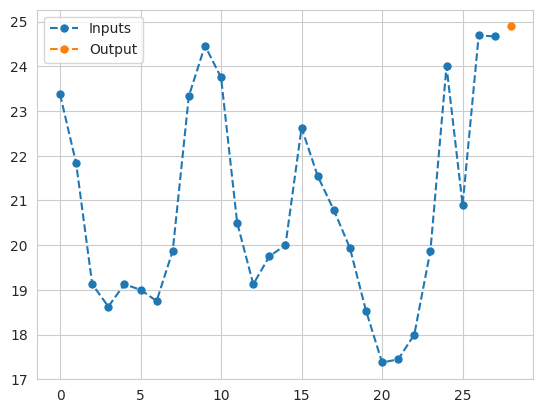

In [151]:
i = 50

inputs = climate_scaler.inverse_transform(X_test[i])
k = preds_test_xgb[i]
outputs = climate_scaler.inverse_transform([[k,k,k,k]])[:,0]


plt.plot(np.arange(28), inputs[:,0], label='Inputs', linestyle='--', marker='o', markersize=5)
plt.plot(np.arange(28,29), outputs, label='Output', linestyle='--', marker='o', markersize=5)
    
plt.legend()
plt.show()

### Saving the results

In [164]:
torch.save(climate_model.state_dict(), 'climate_model.pth')
joblib.dump(climate_xgb_model, "climate_xgb_model.joblib")
joblib.dump(climate_scaler, "climate_scaler.joblib")
climate_results.to_csv("climate_lstm_results.csv", index=False)